In [3]:
import numpy as np 
import pandas as pd 
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score
import Levenshtein
import jellyfish
from fuzzywuzzy import fuzz
from sklearn.metrics import precision_score, recall_score, f1_score
import xml.etree.ElementTree as ET

In [4]:
file1='C:/Users/miste/Mediated_SchemaEdit (1).xml'
file2='C:/Users/miste/countries_of_the_worldEdit.xml'
file3='C:/Users/miste/country_profile_variablesEdit (1).xml'
file4='C:/Users/miste/Human_Development_Index_and_Components.xml'

## Ground truth

In [5]:
file5 = 'C:/Users/miste/GroundTruthCountriesOfTheWorldTask3_1_.csv'
file6 = 'C:/Users/miste/groundTruthCountryProfVarsTask3_2_.csv'
file7 = 'C:/Users/miste/groundTruthHDITask3_3_.csv'

## XML parse functions

In [6]:
def get_element_paths(element, path, element_paths):
    element_paths.append(path)
    for child in element:
        child_path = f"{path}/{child.tag}"
        get_element_paths(child, child_path, element_paths)
    return element_paths

In [7]:
def parse_XML_tree(xml_file_to_parse):
    # Parse the XML file
    tree = ET.parse(xml_file_to_parse)
    root = tree.getroot()

    # Initialize list to store element paths
    element_paths = []

    # Get element paths
    element_paths = get_element_paths(root, root.tag, element_paths)
    return element_paths

## Extraction functions

In [8]:
def extract_nodes(paths, last_amount):
    last_nodes = []

    # Iterate through each element
    for element in paths:
        paths = element.split('/')  # Split the string using the delimiter '/'
        last = '/'.join(paths[-last_amount:])  # Extract the last x nodes and join them with '/'
        last_nodes.append(last)  # Add the last two nodes to the new list
    return last_nodes

## Matcher functions

In [9]:
"""
calculate_semantic_similarity(mediatedSchema_columns, dataSource_columns)
- mediatedSchema_columns - list of mediatedSchema columns names (list)
- dataSource_columns - list of datasource columns names (list)
"""
def calculate_semantic_similarity(mediatedSchema_columns, dataSource_columns):
# Create an empty DataFrame    
    result = pd.DataFrame(columns=['MediatedSchema Attribute'] + dataSource_columns)
    
# Calculate similarity ratios and populate the DataFrame    
    for i in mediatedSchema_columns:
        row = [i]
        for j in dataSource_columns:
            similarity_ratio = fuzz.ratio(i, j)
            row.append(similarity_ratio)
        result.loc[len(result)] = row
    
# Set 'MediatedSchema Attribute' as the index
    result.set_index('MediatedSchema Attribute', inplace=True)
    result = pd.DataFrame(result, index=mediatedSchema_columns, columns=dataSource_columns)
    return result

In [10]:
"""
jaccard(str1, str2)
calculates jaccard similarity score for 2 strings
"""
def jaccard(str1, str2):
    set1 = set(str1)  # Convert string 1 to a set of characters
    set2 = set(str2)  # Convert string 2 to a set of characters

    intersection = set1.intersection(set2)  # Compute the intersection of the two sets
    union = set1.union(set2)  # Compute the union of the two sets

    jaccard_score = len(intersection) / len(union)  # Calculate the Jaccard similarity score

    return jaccard_score

In [11]:
"""
calculate_jaccard_similarity(mediatedSchema_columns, dataSource_columns)
- mediatedSchema_columns - list of mediatedSchema columns names (list)
- dataSource_columns - list of datasource columns names (list)
"""
def calculate_jaccard_similarity(mediatedSchema_columns, dataSource_columns):
# Create a two-dimensional array to store the Jaccard similarity scores
    jaccardScoresTable = [[0.0] * len(dataSource_columns) for _ in range(len(mediatedSchema_columns))]

# Calculate Jaccard similarity between each pair of strings and store the scores
    for i in range(len(mediatedSchema_columns)):
        for j in range(len(dataSource_columns)):
            jaccardScoresTable[i][j] = jaccard(mediatedSchema_columns[i], dataSource_columns[j])*100

# Create a DataFrame from the scores
    result = pd.DataFrame(jaccardScoresTable, index=mediatedSchema_columns, columns=dataSource_columns)
    
    return result

In [12]:
"""
calculate_levenstein_distance(mediatedSchema_columns, dataSource_columns)
- mediatedSchema_columns - list of mediatedSchema columns names (list)
- dataSource_columns - list of datasource columns names (list)
"""

def calculate_levenstein_distance(mediatedSchema_columns, dataSource_columns):
    distances = []
    for string1 in mediatedSchema_columns:
        for string2 in dataSource_columns:
            distance = Levenshtein.distance(string1, string2)
            distances.append(distance)

# Create a two-dimensional array to store the distances
    distances_array = [[distances[i * len(dataSource_columns) + j] for j in range(len(dataSource_columns))] for i in range(len(mediatedSchema_columns))]

# Create a DataFrame from the distances
    result = pd.DataFrame(distances_array, index=mediatedSchema_columns, columns=dataSource_columns)
    
    return result


## Combiner functions

In [13]:
def apply_average_combiner(df1, df2, df3):
    combined_df = pd.concat([df1, df2, df3])  # Combine the dataframes vertically
    averaged_df = combined_df.groupby(combined_df.index).mean()  # Calculate the average by index
    return averaged_df, "Average"

In [14]:
def apply_max_combiner(df1, df2, df3):
    combined_df = pd.concat([df1, df2, df3])  # Combine the dataframes vertically
    averaged_df = combined_df.groupby(combined_df.index).max()  # Calculate max by index
    return averaged_df, "Max"

In [15]:
def apply_min_combiner(df1, df2, df3):
    combined_df = pd.concat([df1, df2, df3])  # Combine the dataframes vertically
    averaged_df = combined_df.groupby(combined_df.index).min()  # Calculate min by index
    return averaged_df, "Min"

## Thresholding functions

In [16]:
'''
Applies threshold to the datasource. If x <= threshold set x t 0
'''
def apply_threshold(df, threshold):
    for column in df.columns:
        df[column] = df[column].apply(lambda x: 0 if x < threshold else x)
    return df 

In [17]:
def convert_to_ones(df):
    for column in df.columns:
        df[column] = df[column].apply(lambda x: 1 if x < threshold else 0)
    return df 

## Cardinality + Selection functions

In [18]:
def apply_cardinality_one_to_one(df):
    greatest_elements = []

    # Iterate over each column
    for column in df.columns:
        # Find the maximum value and its corresponding index
        max_value = df[column].max()
        if max_value == 0:
            continue
        max_row_name = df[df[column] == max_value].index[0]
        
        # Store the greatest element, column name, and row name
        greatest_elements.append((max_value, column, max_row_name))
        #change max value of a column to 1
        df.loc[df[column] == max_value, column] = 100

    return greatest_elements, df

## Misc functions

In [19]:
"""
showData(dataToShow, sizeX, sizeY, title, labelX, labelY)
- dataToShow - pandas DataFrame with data to show (DataFrame);
- sizeX - size of plot by X-axis (int)
- sizeY - size of plot by Y-axis (int)
- title - title of the plot (string)
- labelX - name of label of X-axis (string)
- labelY - name of label of Y-axis (string)
"""
def showData(dataToShow, sizeX, sizeY, title, labelX, labelY):
    plt.figure(figsize=(sizeX, sizeY))
    sns.heatmap(dataToShow, annot=True, cmap='YlGnBu', fmt='.0f')

    # Set the plot title and axis labels
    plt.title(title)
    plt.xlabel(labelX)
    plt.ylabel(labelY)

    # Display the plot
    plt.show()

In [20]:
'''
For calculating metrics we use modules from libarary ScikitLearn
'''
def showMetrics(ground_truth, predicted_data):
    precision = precision_score(ground_truth, predicted_data,pos_label=1, average='micro')
    recall = recall_score(ground_truth, predicted_data, pos_label=1, average='micro')
    f1 = f1_score(ground_truth, predicted_data, pos_label=1, average='micro')
    print('Presicion: ' + str(precision))
    print('Recall: ' + str(recall))
    print('F1 score: ' + str(f1))

In [21]:
def convert_to_ones(df):
    for column in df.columns:
        df[column] = df[column].apply(lambda x: 1 if x == 100 else 0)
    return df 

## Make paths from XML files

In [22]:
ms_paths = parse_XML_tree(file1)
dataSource1_paths = parse_XML_tree(file2)
dataSource2_paths = parse_XML_tree(file3)
dataSource3_paths = parse_XML_tree(file4)

# Full paths strategy

## Produce Matcher matrices

In [23]:
dataSource1_SemanticSimilarity = calculate_semantic_similarity(ms_paths, dataSource1_paths)
dataSource1_Jaccard = calculate_jaccard_similarity(ms_paths, dataSource1_paths)
dataSource1_Levenstein = calculate_levenstein_distance(ms_paths, dataSource1_paths)

dataSource2_SemanticSimilarity = calculate_semantic_similarity(ms_paths, dataSource2_paths)
dataSource2_Jaccard = calculate_jaccard_similarity(ms_paths, dataSource2_paths)
dataSource2_Levenstein = calculate_levenstein_distance(ms_paths, dataSource2_paths)

dataSource3_SemanticSimilarity = calculate_semantic_similarity(ms_paths, dataSource3_paths)
dataSource3_Jaccard = calculate_jaccard_similarity(ms_paths, dataSource3_paths)
dataSource3_Levenstein = calculate_levenstein_distance(ms_paths, dataSource3_paths)


## Show Matchers Matrices

## Datasource 1

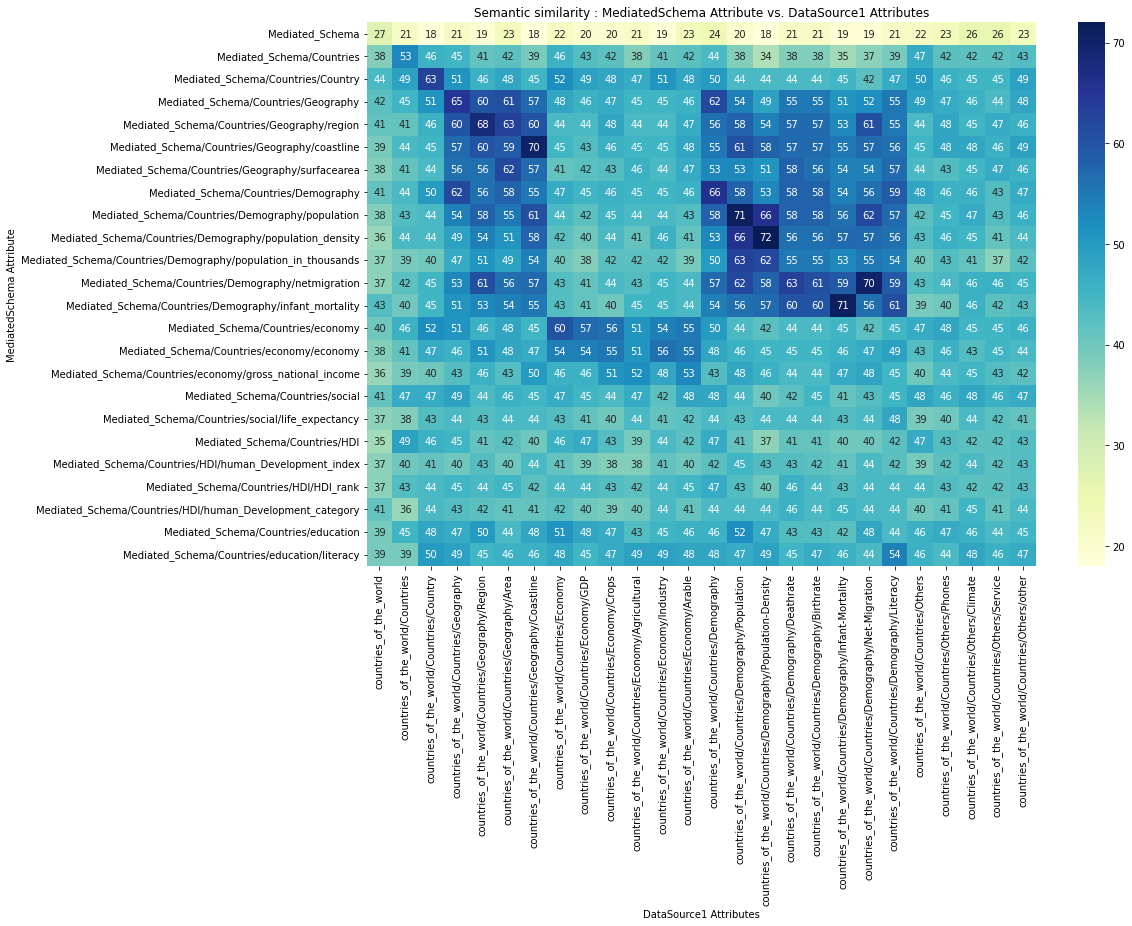

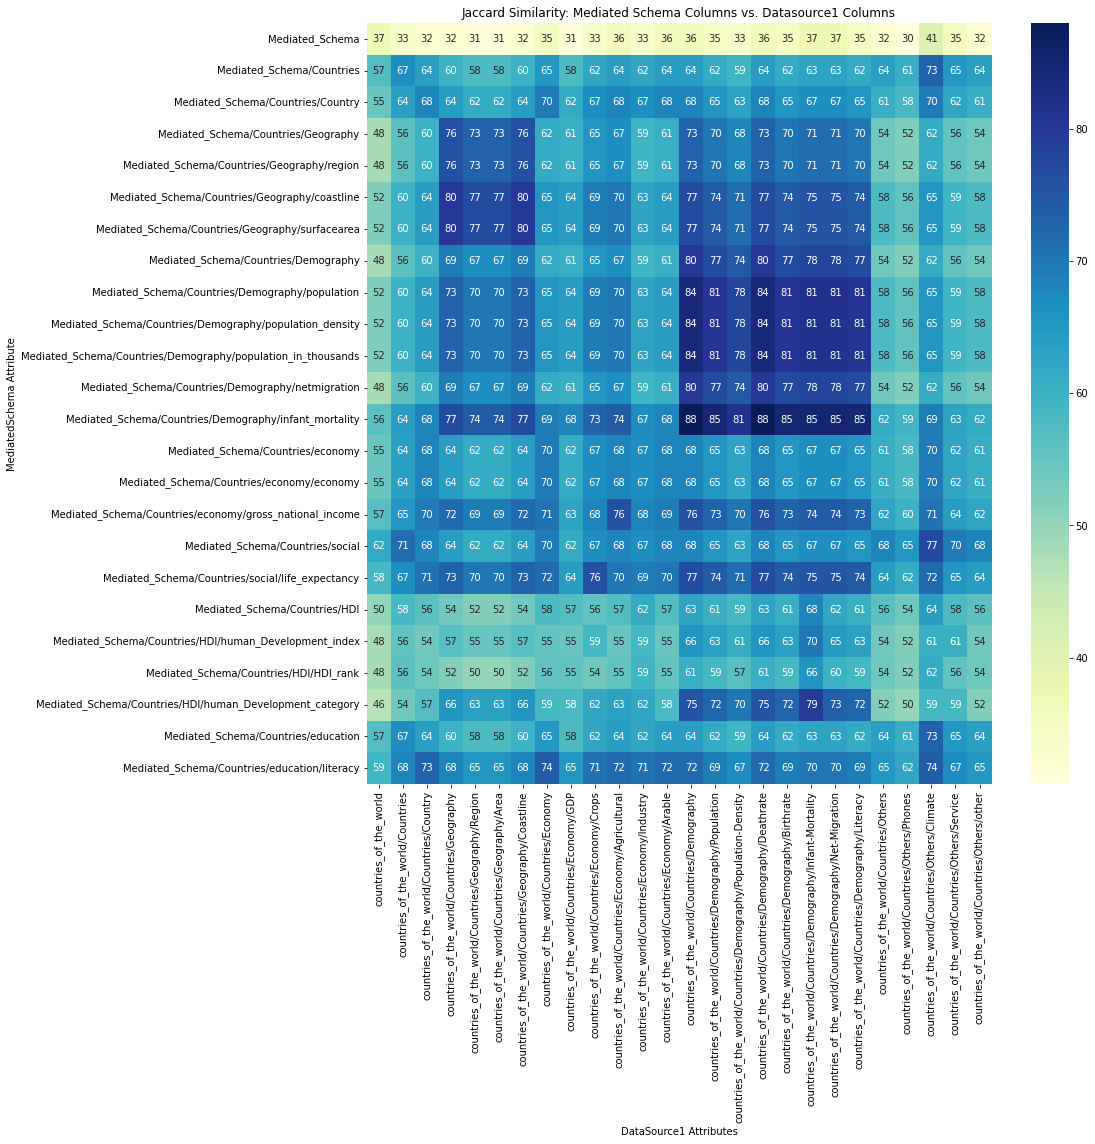

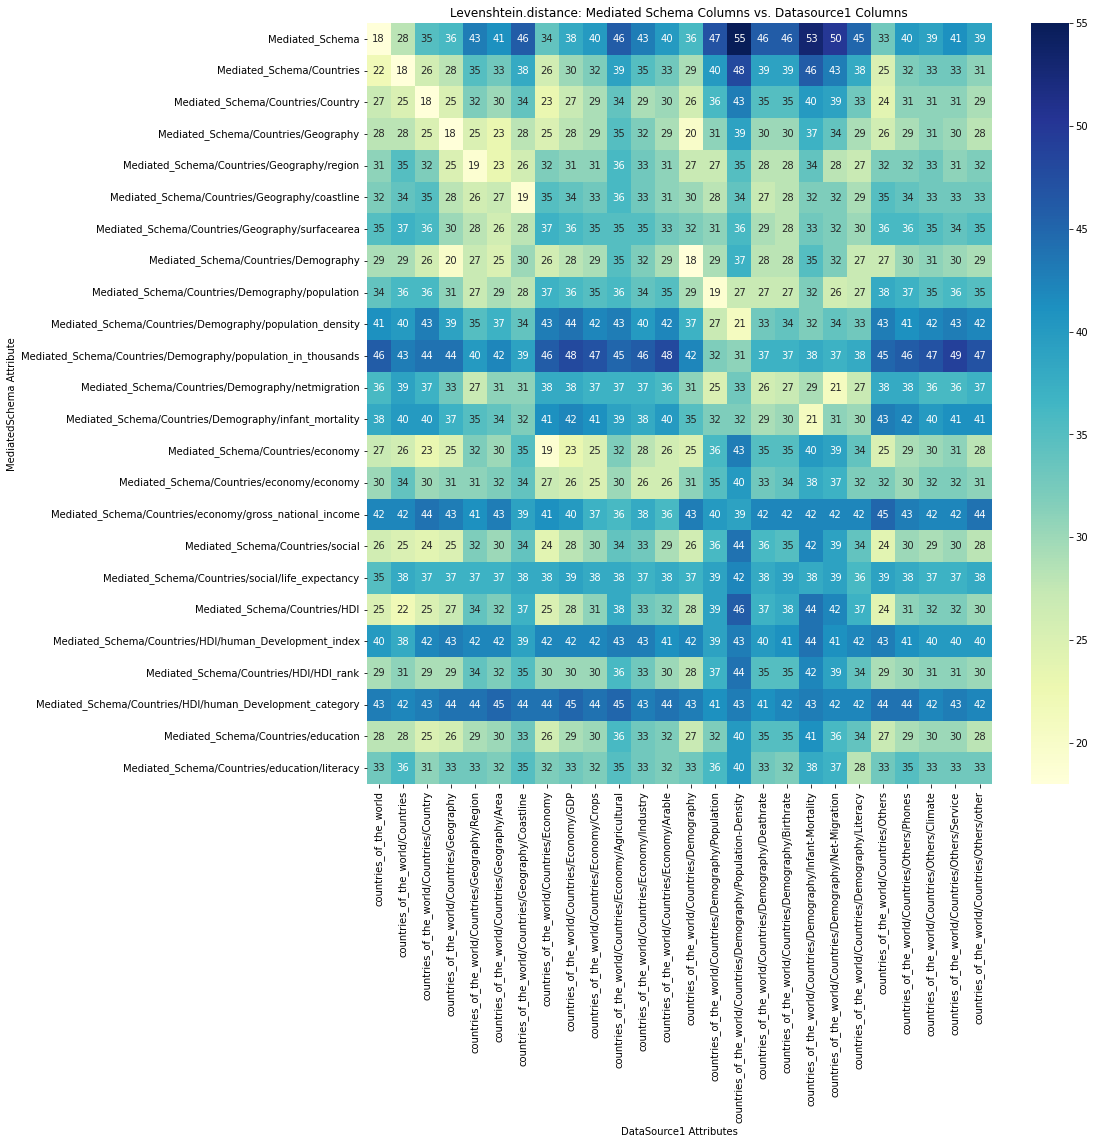

In [24]:
showData(dataSource1_SemanticSimilarity,15,10, 'Semantic similarity : MediatedSchema Attribute vs. DataSource1 Attributes', 'DataSource1 Attributes', 'MediatedSchema Attribute')
showData(dataSource1_Jaccard,14,14, 'Jaccard Similarity: Mediated Schema Columns vs. Datasource1 Columns', 'DataSource1 Attributes', 'MediatedSchema Attribute')
showData(dataSource1_Levenstein,14,14, 'Levenshtein.distance: Mediated Schema Columns vs. Datasource1 Columns', 'DataSource1 Attributes', 'MediatedSchema Attribute')

## Datasource 2

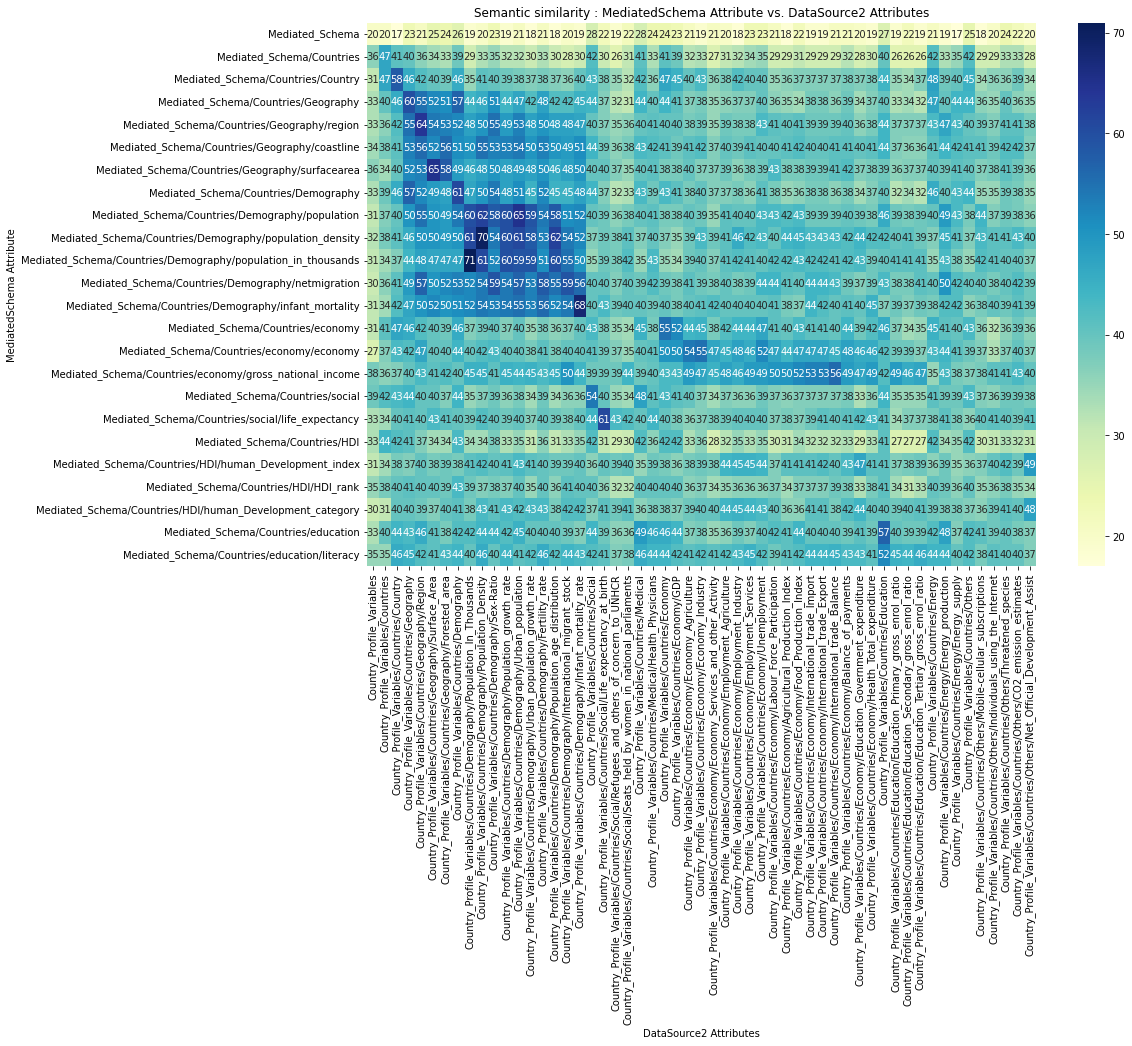

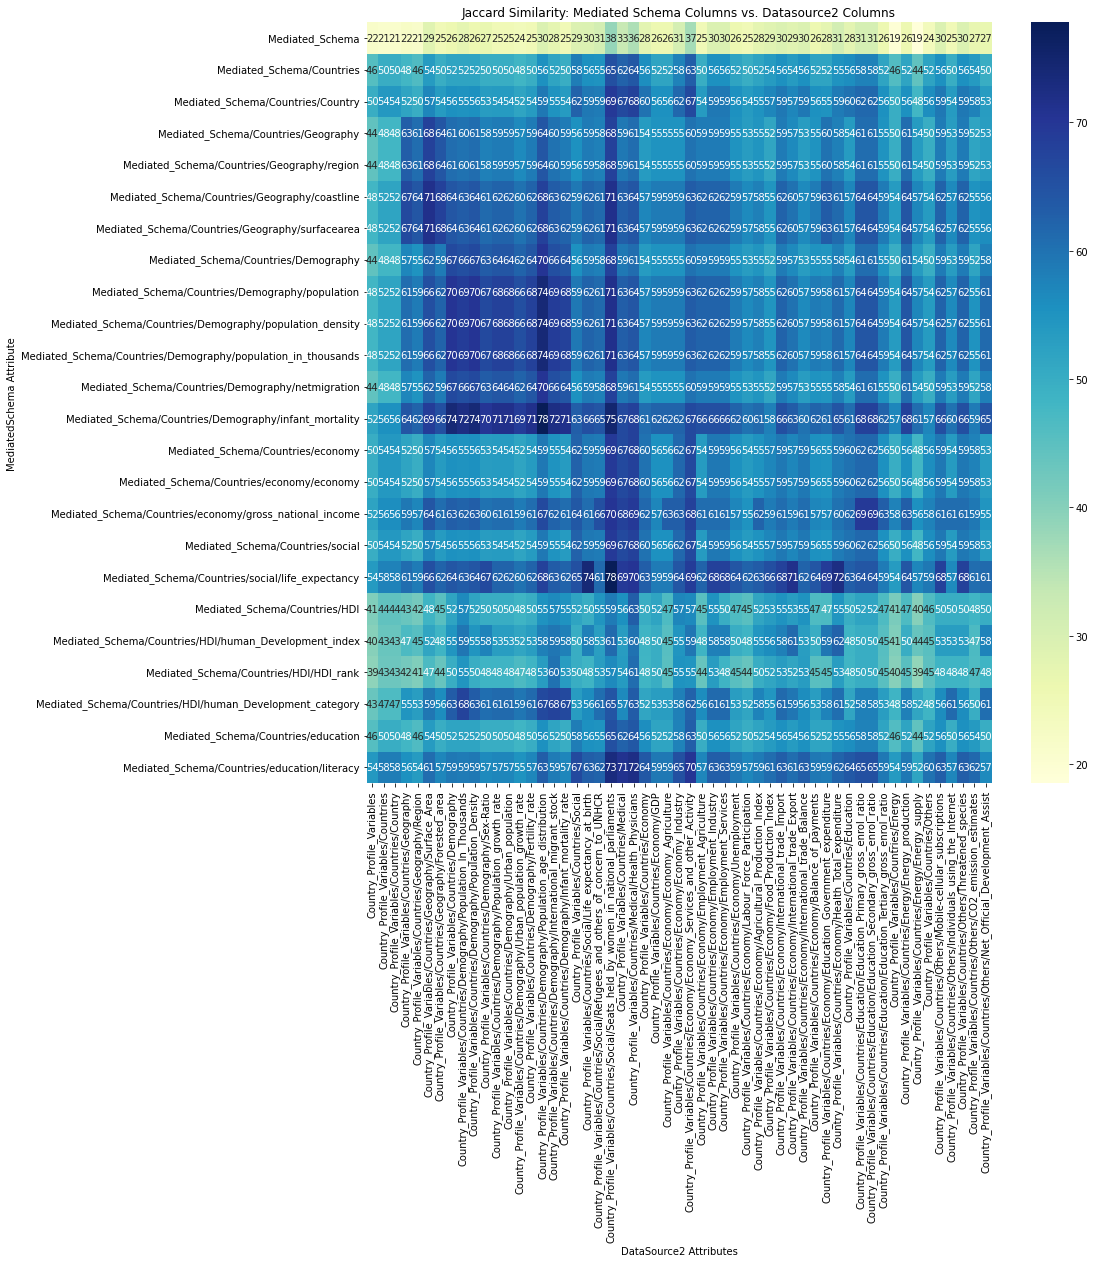

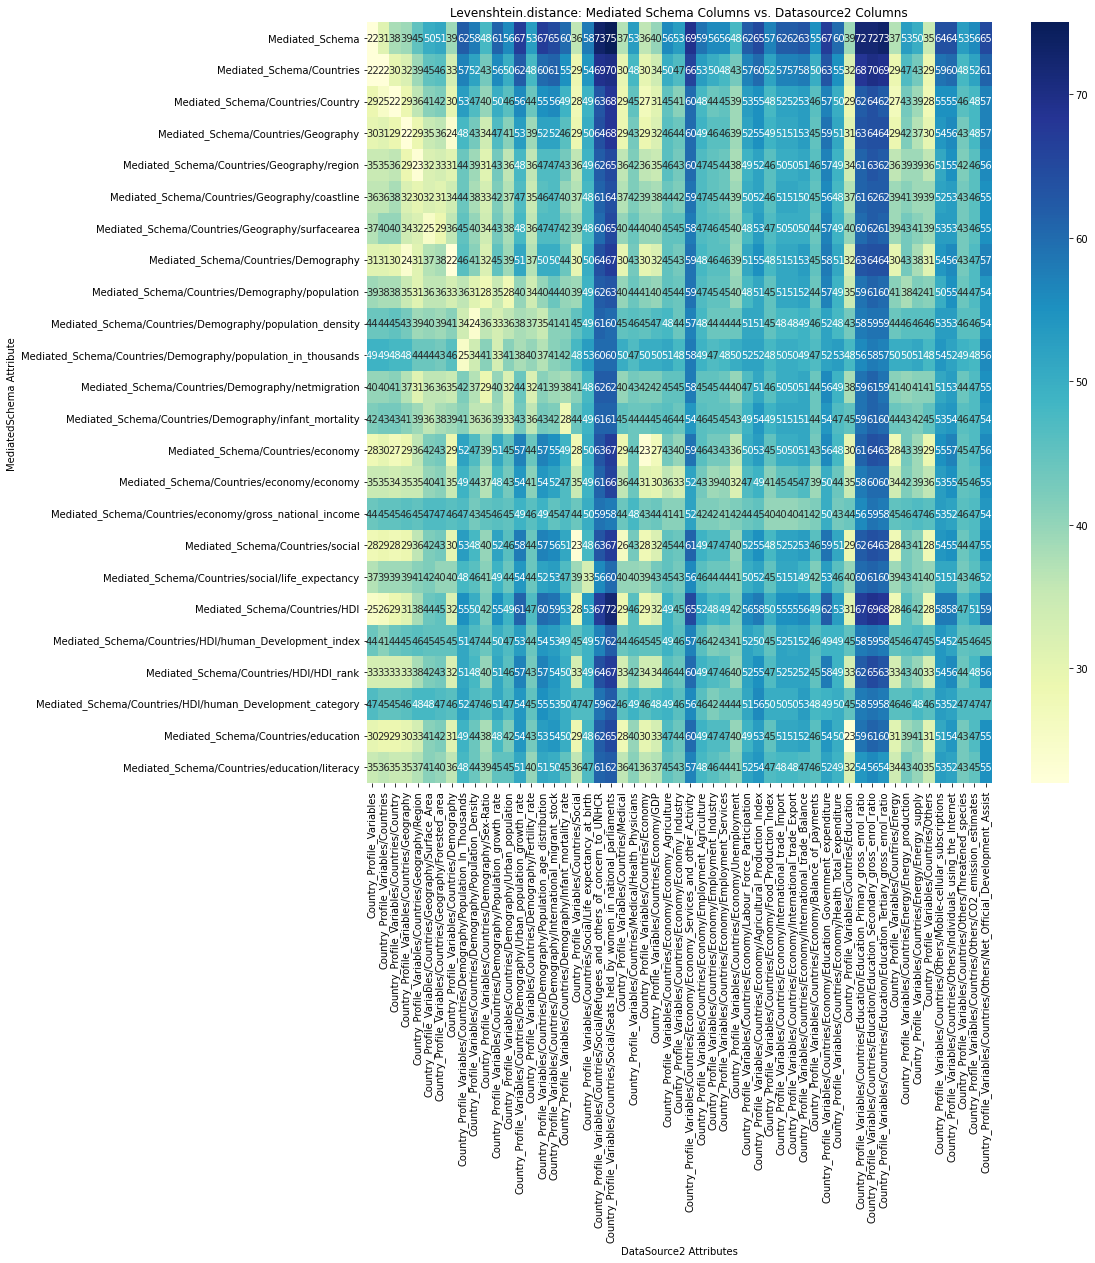

In [25]:
showData(dataSource2_SemanticSimilarity,15,10, 'Semantic similarity : MediatedSchema Attribute vs. DataSource2 Attributes', 'DataSource2 Attributes', 'MediatedSchema Attribute')
showData(dataSource2_Jaccard,14,14, 'Jaccard Similarity: Mediated Schema Columns vs. Datasource2 Columns', 'DataSource2 Attributes', 'MediatedSchema Attribute')
showData(dataSource2_Levenstein,14,14, 'Levenshtein.distance: Mediated Schema Columns vs. Datasource2 Columns', 'DataSource2 Attributes', 'MediatedSchema Attribute')

## Datasource 3

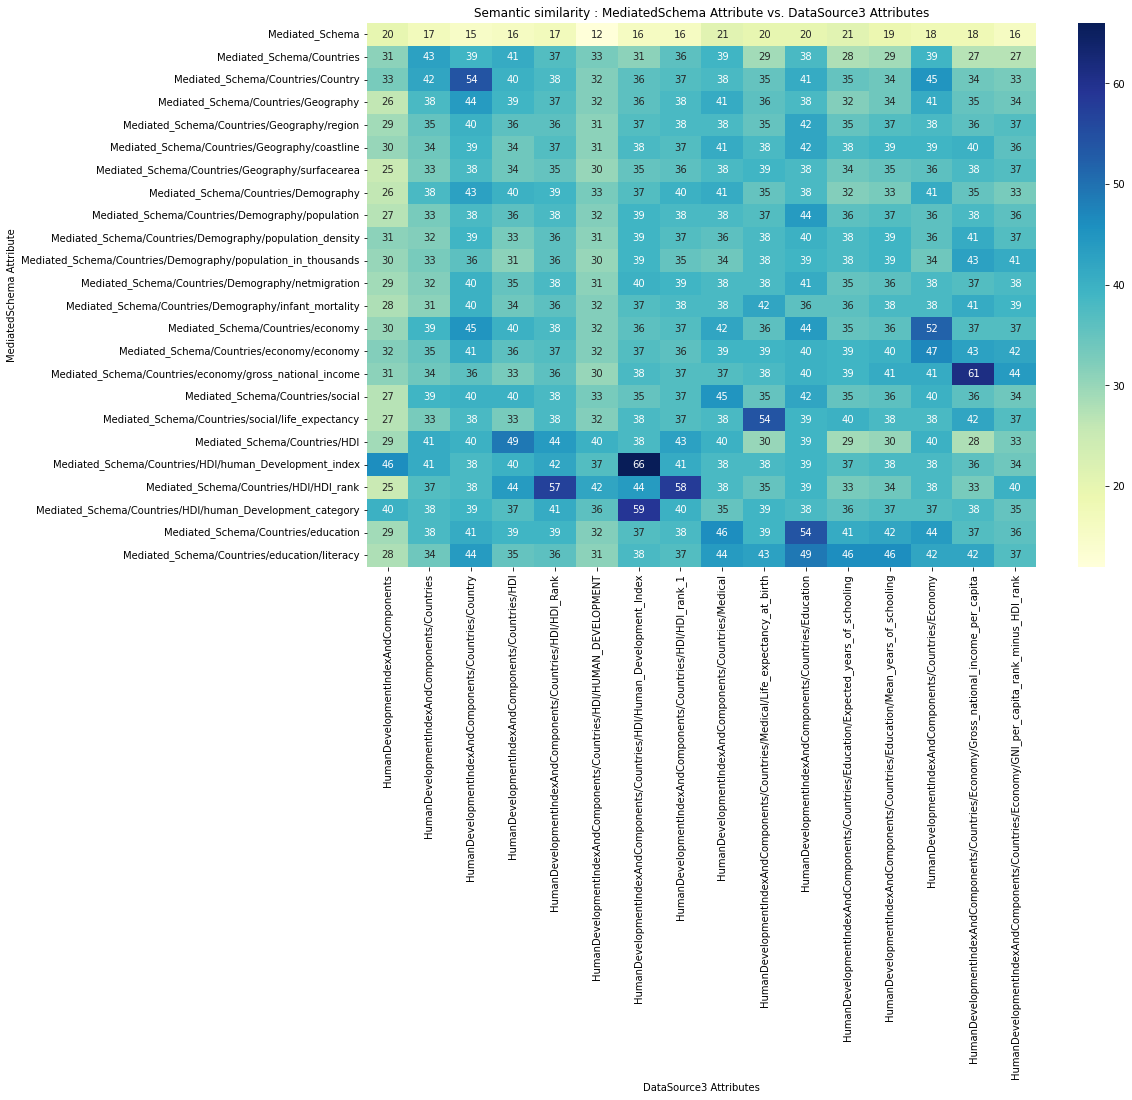

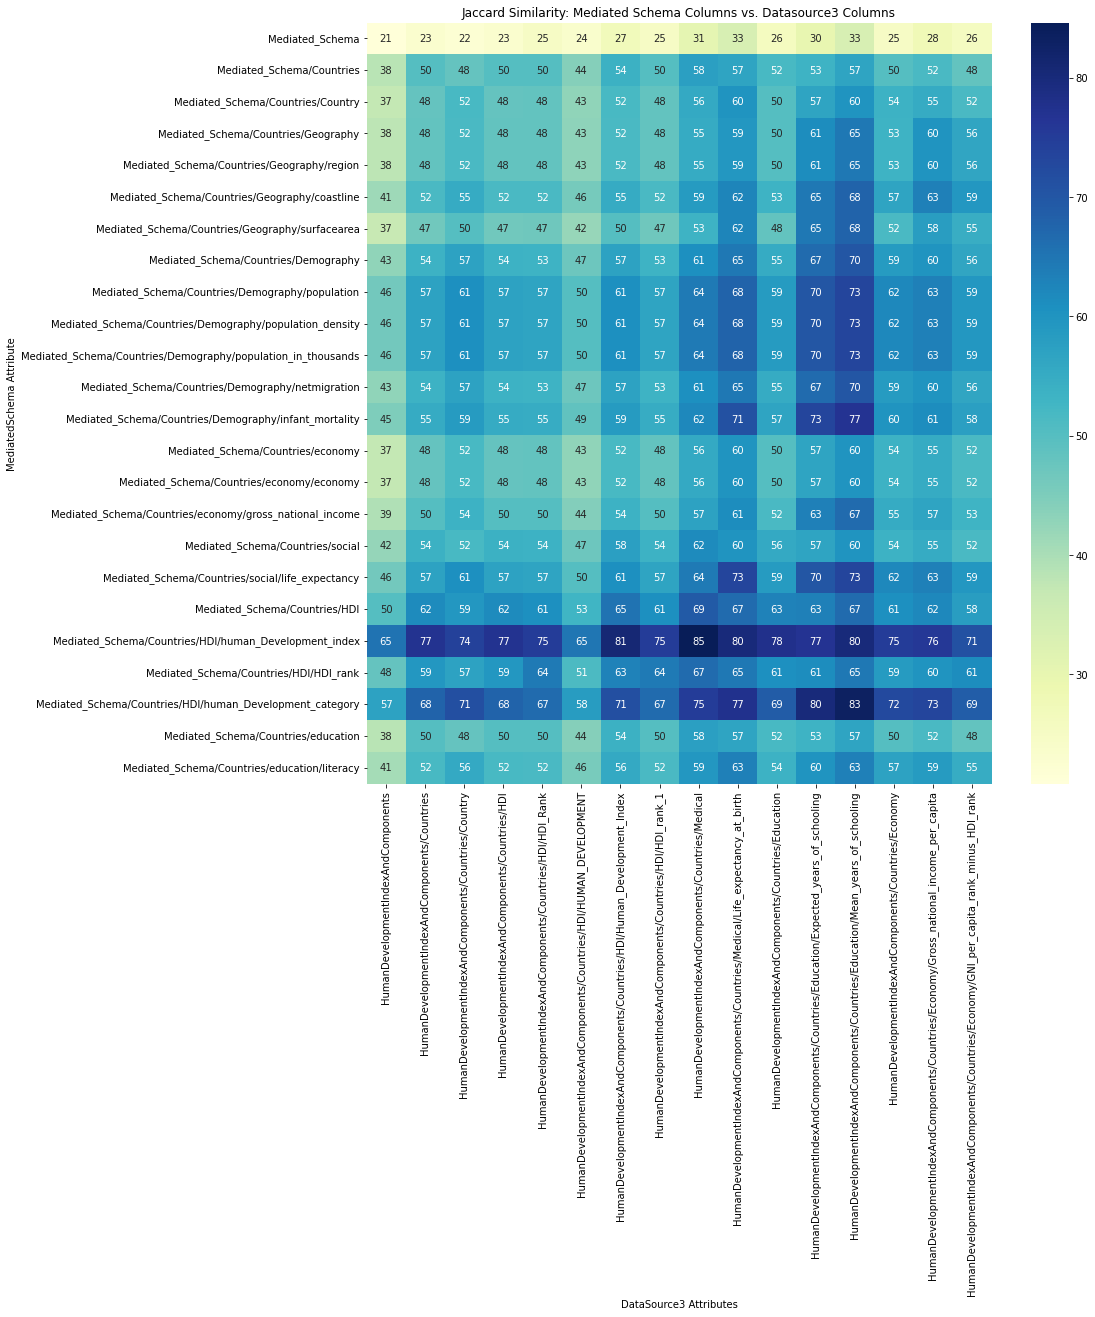

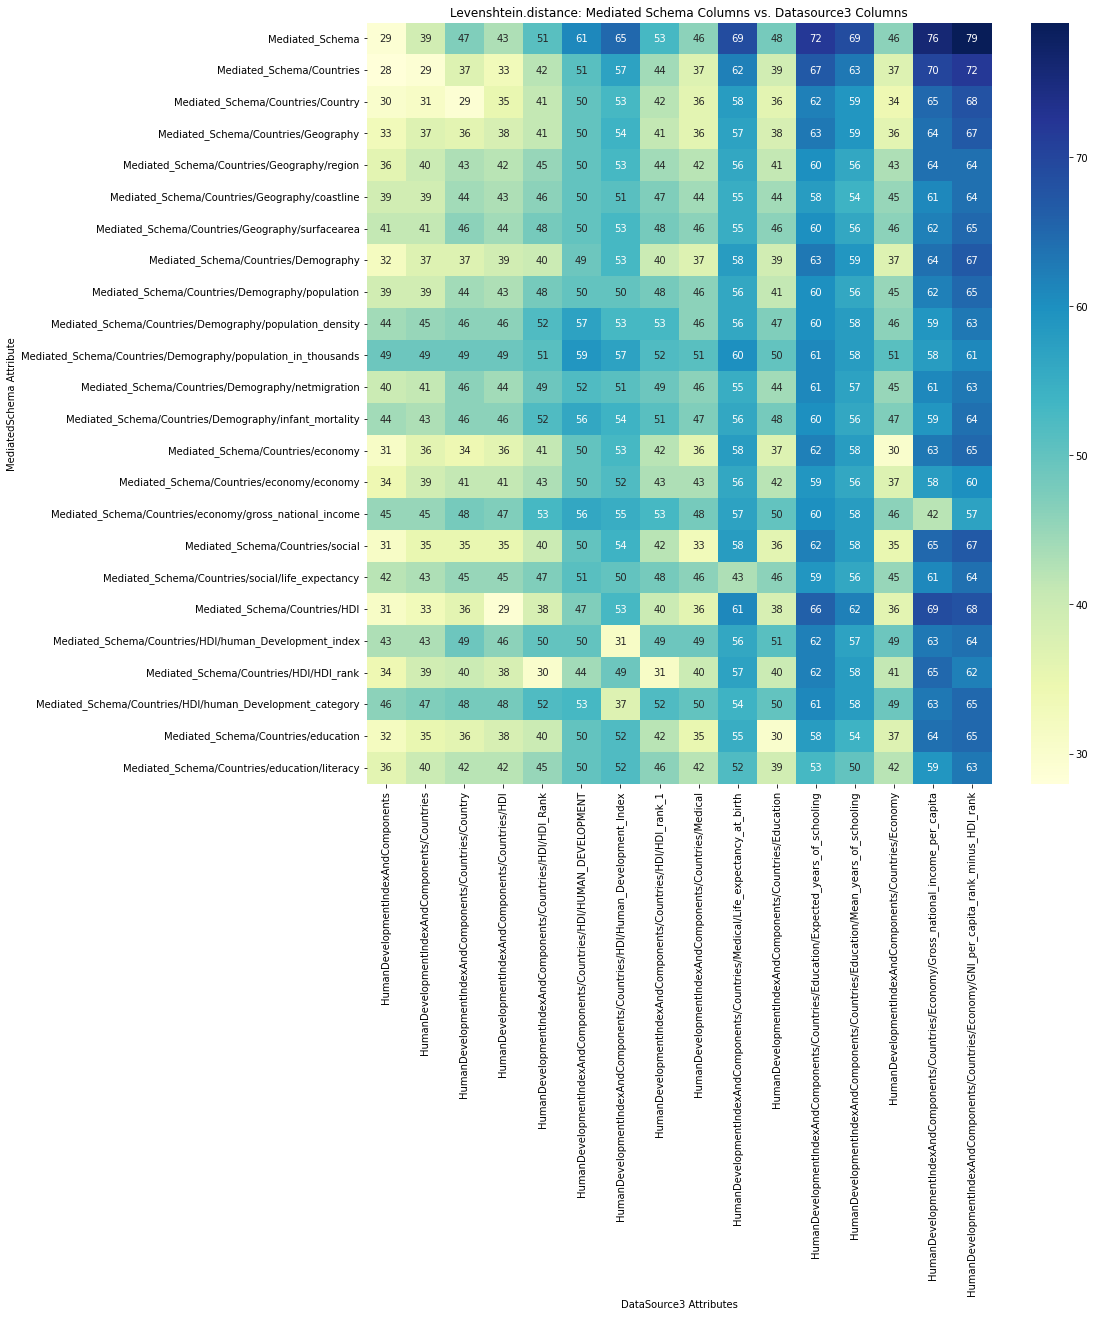

In [26]:
showData(dataSource3_SemanticSimilarity,15,10, 'Semantic similarity : MediatedSchema Attribute vs. DataSource3 Attributes', 'DataSource3 Attributes', 'MediatedSchema Attribute')
showData(dataSource3_Jaccard,14,14, 'Jaccard Similarity: Mediated Schema Columns vs. Datasource3 Columns', 'DataSource3 Attributes', 'MediatedSchema Attribute')
showData(dataSource3_Levenstein,14,14, 'Levenshtein.distance: Mediated Schema Columns vs. Datasource3 Columns', 'DataSource3 Attributes', 'MediatedSchema Attribute')

## Apply combiner to matrices (full paths startegy)

In [27]:
'''
You can pick differnet combiners just changing name of the function, names for different combiners:
apply_max_combiner
apply_min_combiner
apply_average_combiner
'''
dataSource1_combine, ds1_combiner_name = apply_max_combiner(dataSource1_SemanticSimilarity, dataSource1_Jaccard, dataSource1_Levenstein)

dataSource2_combine, ds2_combiner_name = apply_max_combiner(dataSource2_SemanticSimilarity, dataSource2_Jaccard, dataSource2_Levenstein)

dataSource3_combine, ds3_combiner_name = apply_max_combiner(dataSource3_SemanticSimilarity, dataSource3_Jaccard, dataSource3_Levenstein)

## Datasource 1

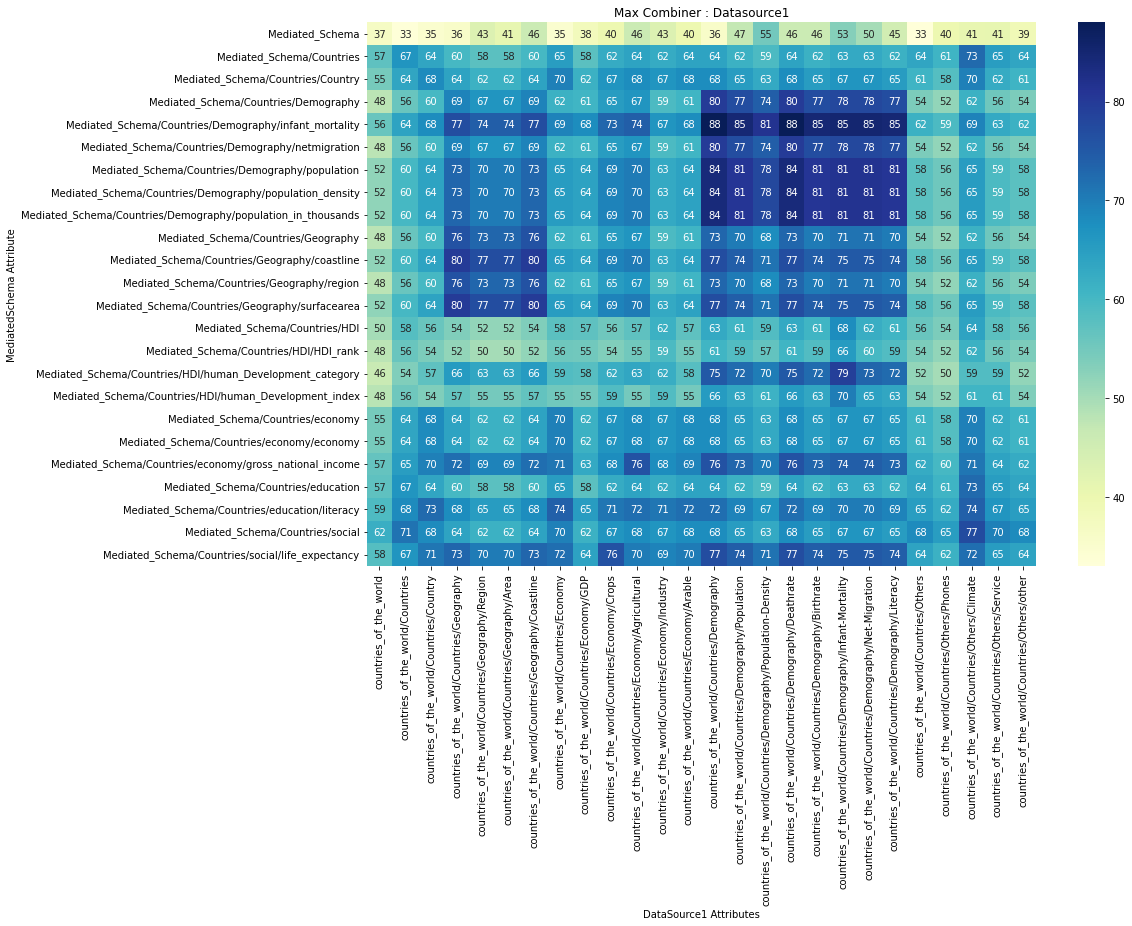

In [28]:
showData(dataSource1_combine,15,10, str(ds1_combiner_name) + ' Combiner : Datasource1', 'DataSource1 Attributes', 'MediatedSchema Attribute')

## Datasource 2

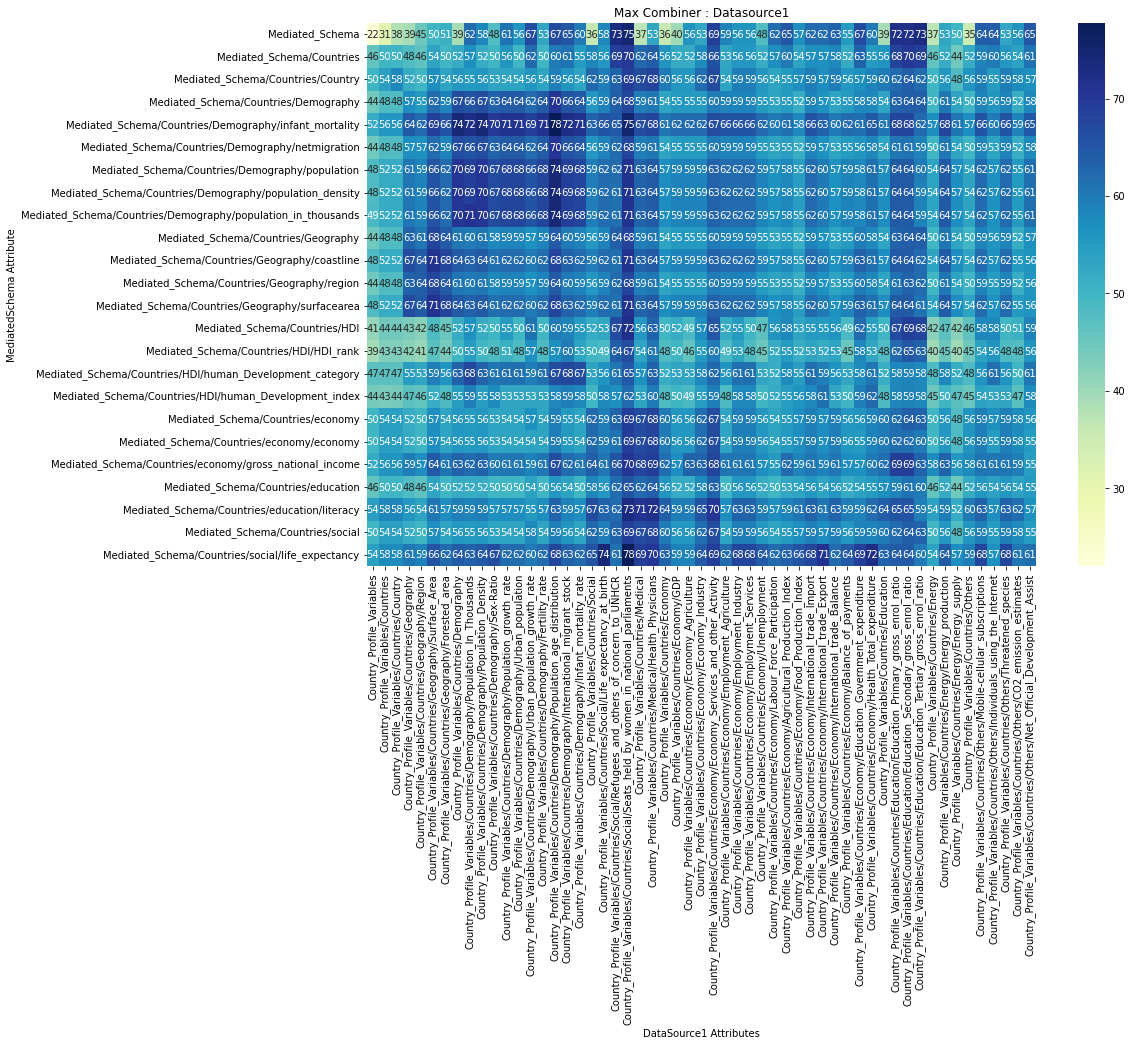

In [29]:
showData(dataSource2_combine,15,10, str(ds1_combiner_name) + ' Combiner : Datasource1', 'DataSource1 Attributes', 'MediatedSchema Attribute')

## Datasource 3

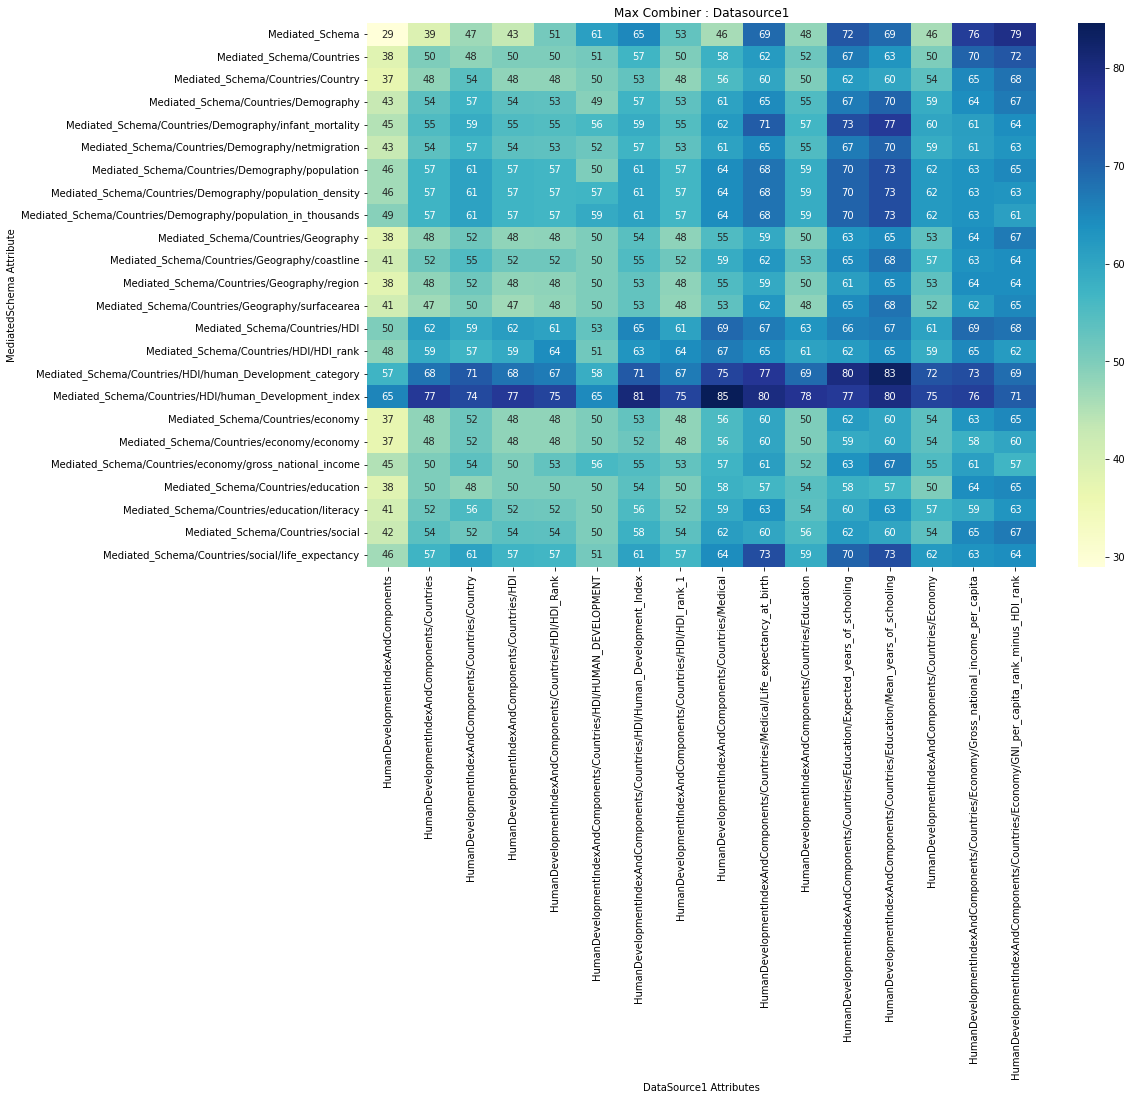

In [30]:
showData(dataSource3_combine,15,10, str(ds1_combiner_name) + ' Combiner : Datasource1', 'DataSource1 Attributes', 'MediatedSchema Attribute')

## Thresholding stage

In [31]:
dS1_threshold = 50
dS2_threshold = 50
dS3_threshold = 50

dataSource1_thresholded = apply_threshold(dataSource1_combine, dS1_threshold)
dataSource2_thresholded = apply_threshold(dataSource2_combine, dS2_threshold)
dataSource3_thresholded = apply_threshold(dataSource3_combine, dS3_threshold)

## Selection Stage

In [32]:
dataSource1_cardinality, dataSource1_selected = apply_cardinality_one_to_one(dataSource1_thresholded)
dataSource2_cardinality, dataSource2_selected = apply_cardinality_one_to_one(dataSource2_thresholded)
dataSource3_cardinality, dataSource3_selected = apply_cardinality_one_to_one(dataSource3_thresholded)

### Convert selected cells to binary (0,1)

In [33]:
dataSource1_selected = convert_to_ones(dataSource1_selected)
dataSource2_selected = convert_to_ones(dataSource2_selected)
dataSource3_selected = convert_to_ones(dataSource3_selected)

## Datasource 1

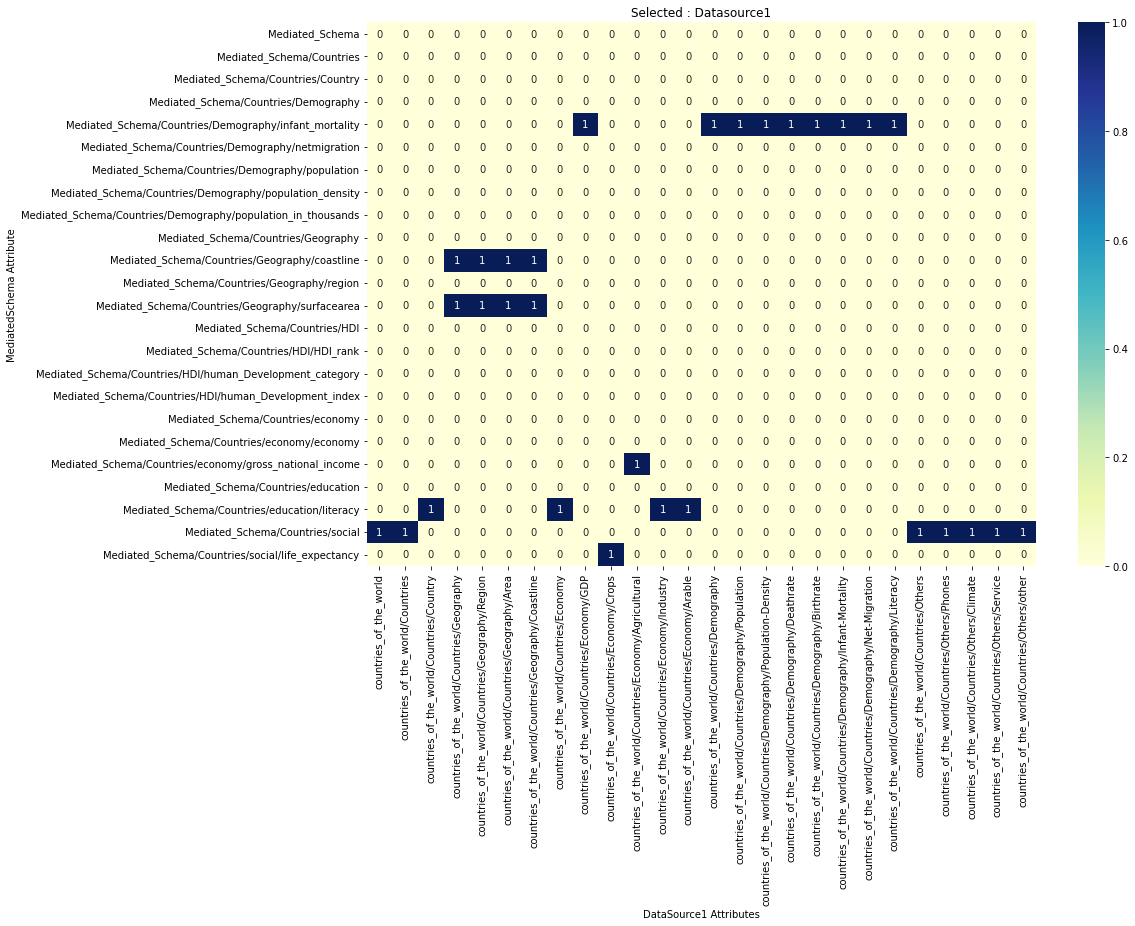

In [34]:
showData(dataSource1_selected,15,10, 'Selected : Datasource1', 'DataSource1 Attributes', 'MediatedSchema Attribute')

## Datasource 2

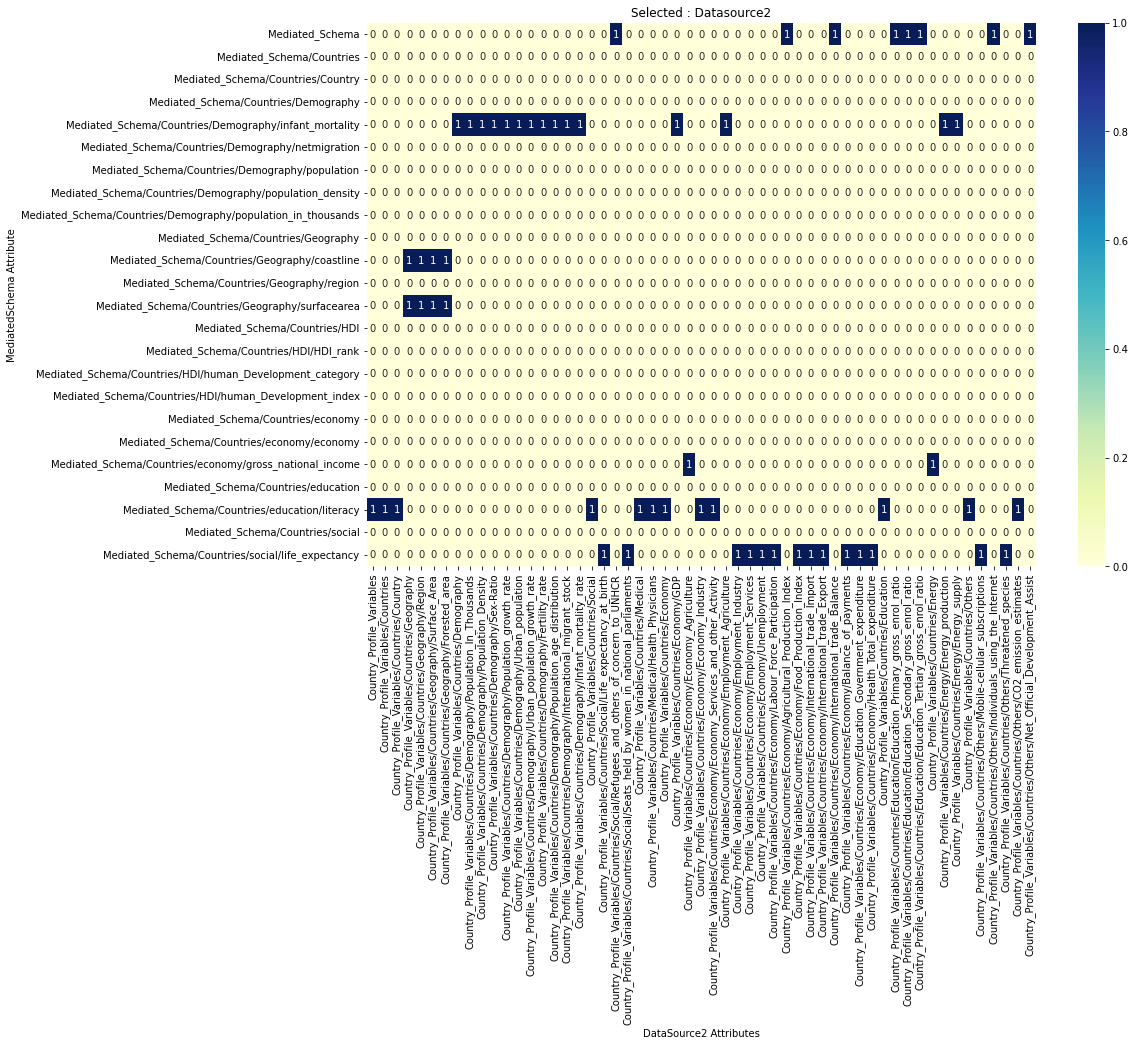

In [35]:
showData(dataSource2_selected,15,10, 'Selected : Datasource2', 'DataSource2 Attributes', 'MediatedSchema Attribute')

## Datasource 3

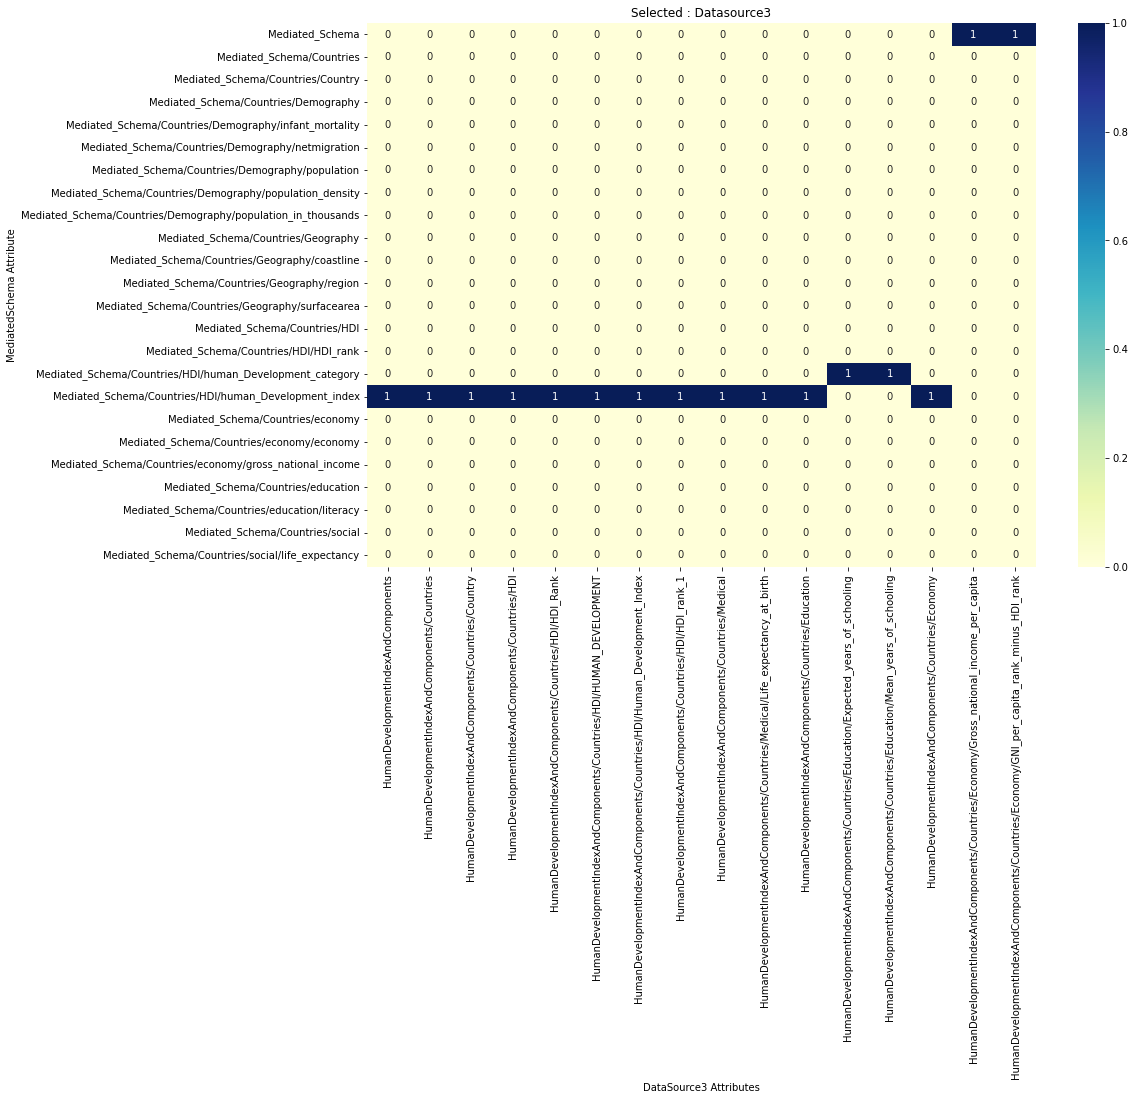

In [36]:
showData(dataSource3_selected,15,10, 'Selected : Datasource3', 'DataSource3 Attributes', 'MediatedSchema Attribute')

## Performance metrics calculation

In [37]:
ground_truth1 = pd.read_csv(file5,index_col=0) 
ground_truth2 = pd.read_csv(file6,index_col=0)
ground_truth3 = pd.read_csv(file7,index_col=0)

In [38]:
ground_truth1_sorted = ground_truth1.sort_index()
ground_truth2_sorted = ground_truth2.sort_index()
ground_truth3_sorted = ground_truth3.sort_index()

## Datasource 1

In [39]:
showMetrics(ground_truth1_sorted, dataSource1_selected)

Presicion: 0.13333333333333333
Recall: 0.3076923076923077
F1 score: 0.18604651162790697


## Datasource 2

In [40]:
showMetrics(ground_truth2_sorted, dataSource2_selected)

Presicion: 0.0847457627118644
Recall: 0.3333333333333333
F1 score: 0.13513513513513511


## Datasource 3

In [41]:
showMetrics(ground_truth3_sorted, dataSource3_selected)

Presicion: 0.0625
Recall: 0.1
F1 score: 0.07692307692307693


# Parent-Child strategy

## Extract Parent-Child from xml sources

In [42]:
ms_parent_child = extract_nodes(ms_paths,2)
dataSource1_parent_child = extract_nodes(dataSource1_paths,2)
dataSource2_parent_child = extract_nodes(dataSource2_paths,2)
dataSource3_parent_child = extract_nodes(dataSource3_paths,2)

## Produce Matcher matrices (Parent-Child startegy)

In [43]:
dataSource1_parent_child_SemanticSimilarity = calculate_semantic_similarity(ms_parent_child, dataSource1_parent_child)
dataSource1_parent_child_Jaccard = calculate_jaccard_similarity(ms_parent_child, dataSource1_parent_child)
dataSource1_parent_child_Levenstein = calculate_levenstein_distance(ms_parent_child, dataSource1_parent_child)

dataSource2_parent_child_SemanticSimilarity = calculate_semantic_similarity(ms_parent_child, dataSource2_parent_child)
dataSource2_parent_child_Jaccard = calculate_jaccard_similarity(ms_parent_child, dataSource2_parent_child)
dataSource2_parent_child_Levenstein = calculate_levenstein_distance(ms_parent_child, dataSource2_parent_child)

dataSource3_parent_child_SemanticSimilarity = calculate_semantic_similarity(ms_parent_child, dataSource3_parent_child)
dataSource3_parent_child_Jaccard = calculate_jaccard_similarity(ms_parent_child, dataSource3_parent_child)
dataSource3_parent_child_Levenstein = calculate_levenstein_distance(ms_parent_child, dataSource3_parent_child)


## Show Matchers Matrices

## Datasource 1

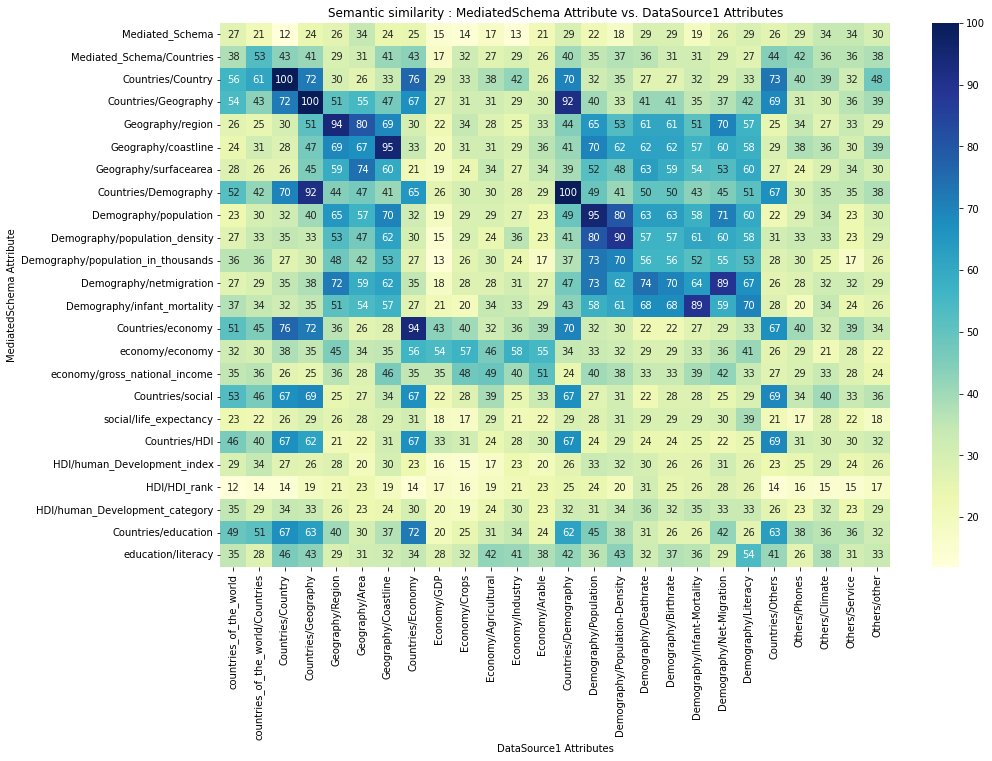

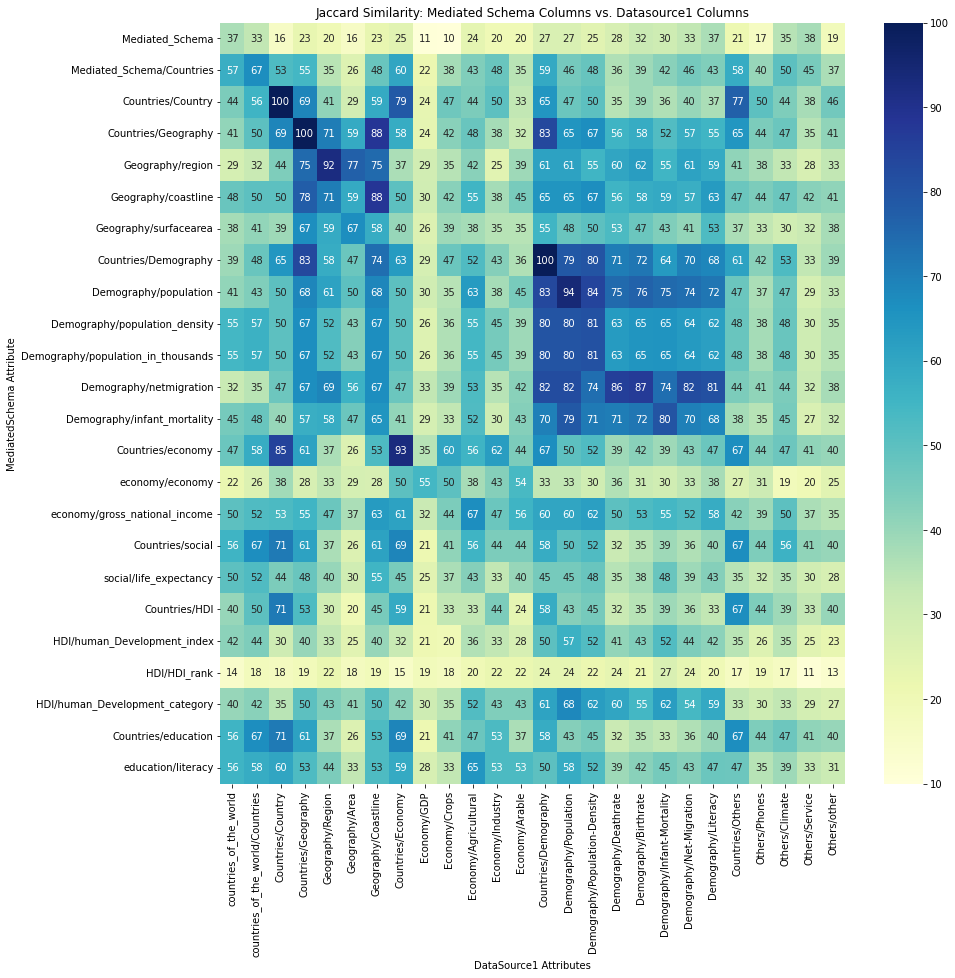

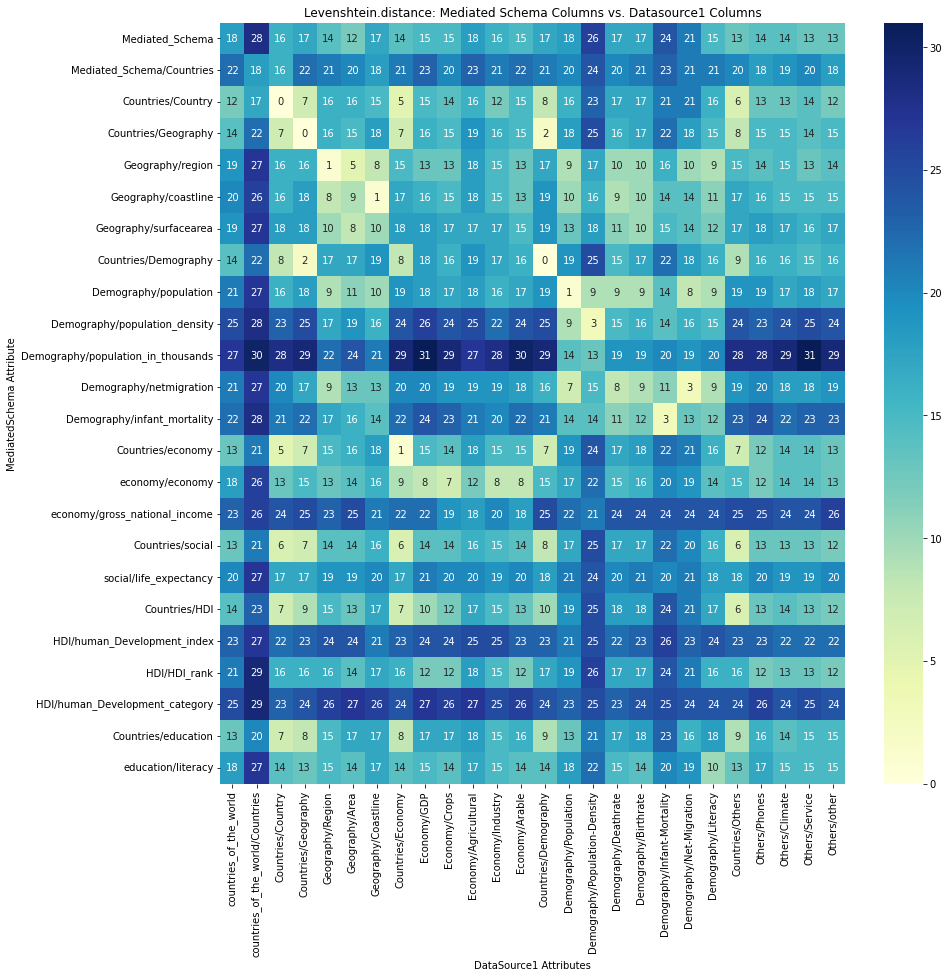

In [44]:
showData(dataSource1_parent_child_SemanticSimilarity,15,10, 'Semantic similarity : MediatedSchema Attribute vs. DataSource1 Attributes', 'DataSource1 Attributes', 'MediatedSchema Attribute')
showData(dataSource1_parent_child_Jaccard,14,14, 'Jaccard Similarity: Mediated Schema Columns vs. Datasource1 Columns', 'DataSource1 Attributes', 'MediatedSchema Attribute')
showData(dataSource1_parent_child_Levenstein,14,14, 'Levenshtein.distance: Mediated Schema Columns vs. Datasource1 Columns', 'DataSource1 Attributes', 'MediatedSchema Attribute')

## Datasource 2

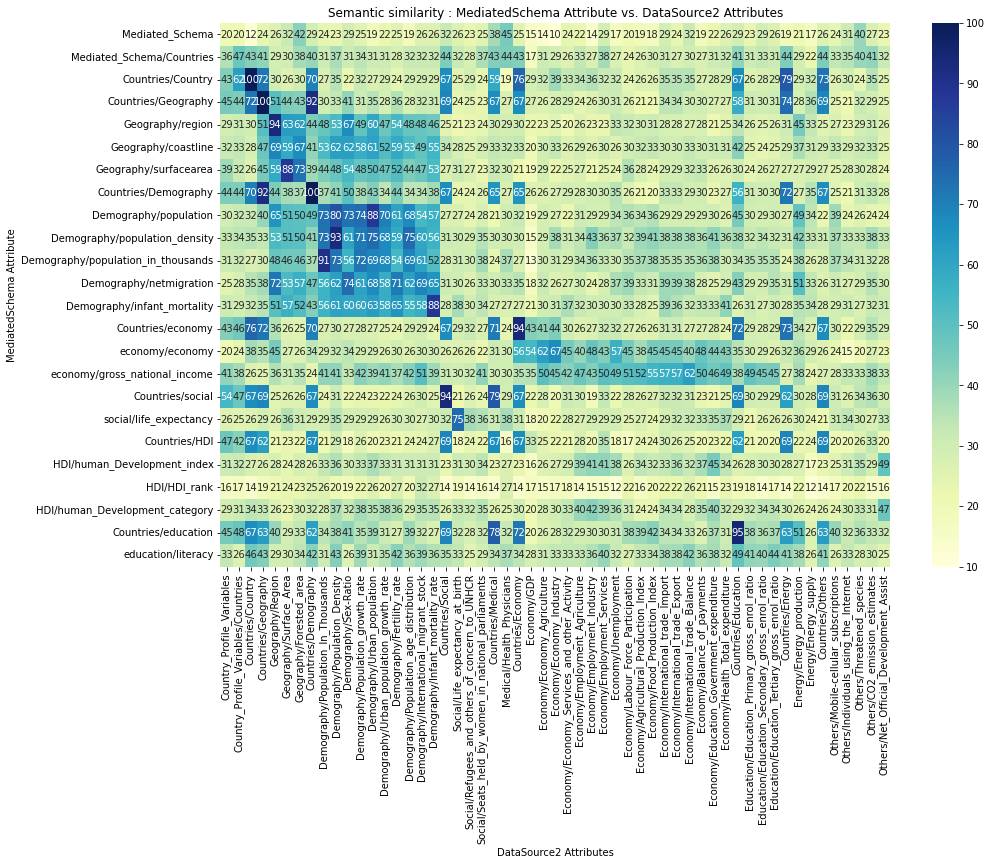

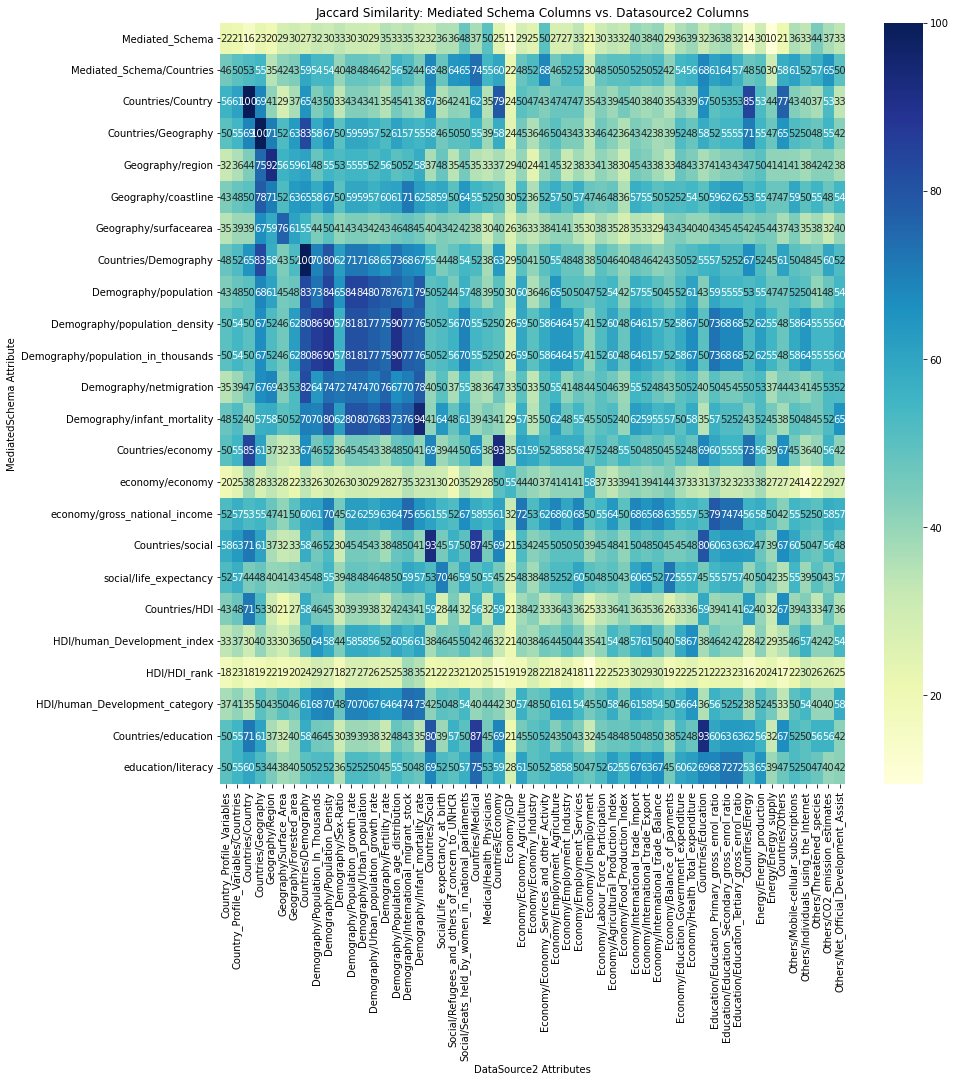

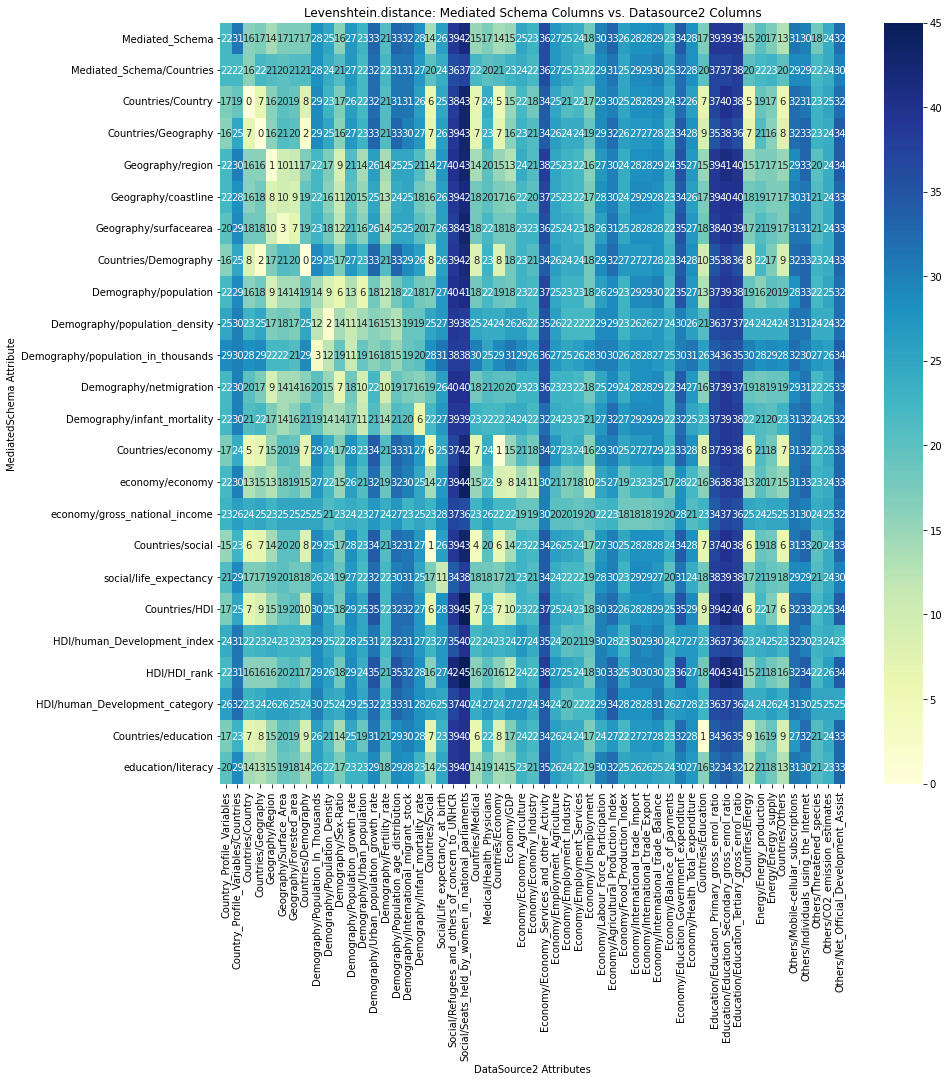

In [45]:
showData(dataSource2_parent_child_SemanticSimilarity,15,10, 'Semantic similarity : MediatedSchema Attribute vs. DataSource2 Attributes', 'DataSource2 Attributes', 'MediatedSchema Attribute')
showData(dataSource2_parent_child_Jaccard,14,14, 'Jaccard Similarity: Mediated Schema Columns vs. Datasource2 Columns', 'DataSource2 Attributes', 'MediatedSchema Attribute')
showData(dataSource2_parent_child_Levenstein,14,14, 'Levenshtein.distance: Mediated Schema Columns vs. Datasource2 Columns', 'DataSource2 Attributes', 'MediatedSchema Attribute')

## Datasorce 3

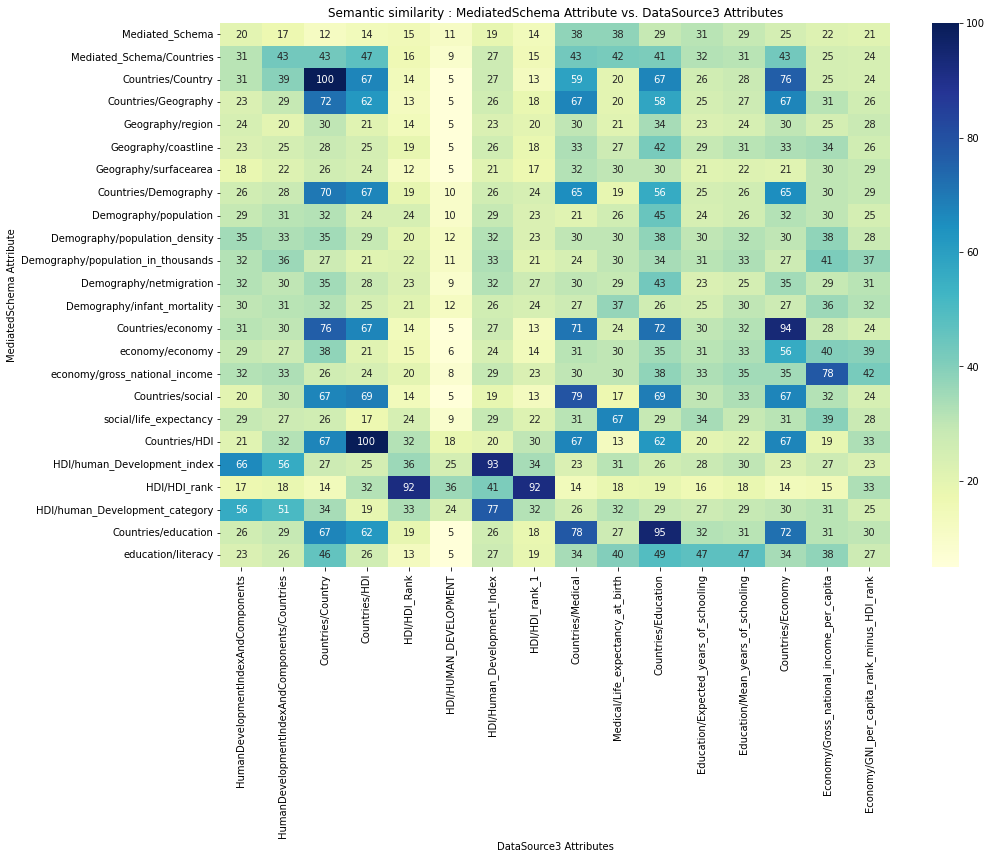

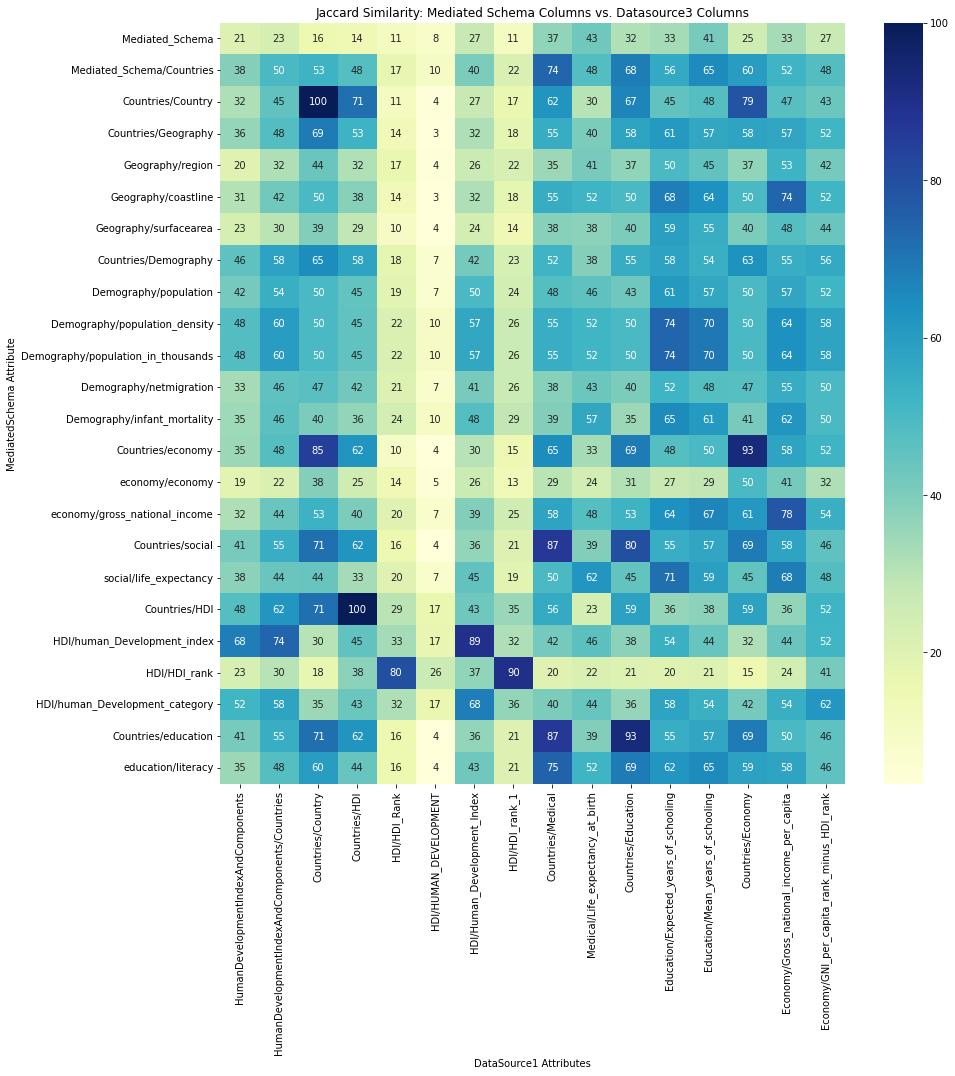

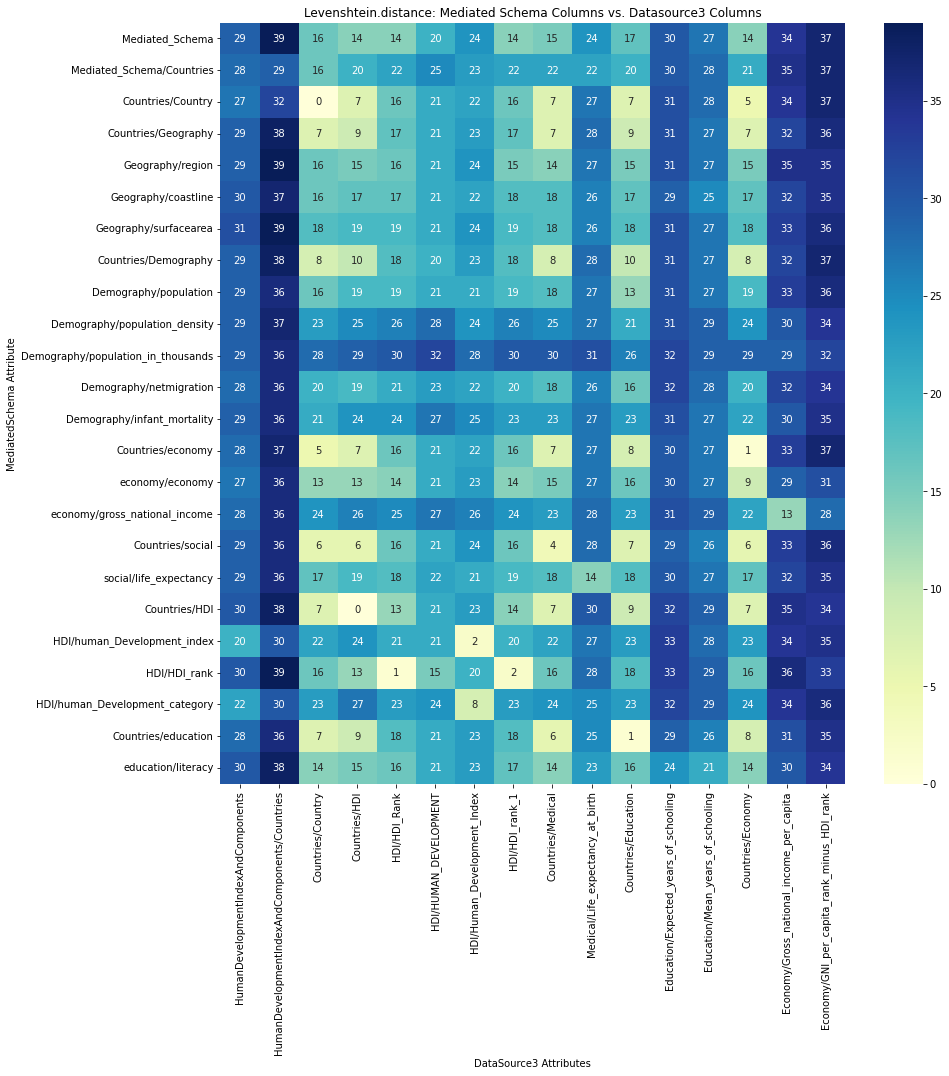

In [46]:
showData(dataSource3_parent_child_SemanticSimilarity,15,10, 'Semantic similarity : MediatedSchema Attribute vs. DataSource3 Attributes', 'DataSource3 Attributes', 'MediatedSchema Attribute')
showData(dataSource3_parent_child_Jaccard,14,14, 'Jaccard Similarity: Mediated Schema Columns vs. Datasource3 Columns', 'DataSource1 Attributes', 'MediatedSchema Attribute')
showData(dataSource3_parent_child_Levenstein,14,14, 'Levenshtein.distance: Mediated Schema Columns vs. Datasource3 Columns', 'DataSource3 Attributes', 'MediatedSchema Attribute')

## Apply combiner to matrices (parent-child startegy)

In [47]:
'''
You can pick differnet combiners just changing name of the function, names for different combiners:
apply_max_combiner
apply_min_combiner
apply_average_combiner
'''
dataSource1_combine_parent_child, ds1_combiner_name_parent_child = apply_max_combiner(dataSource1_parent_child_SemanticSimilarity, dataSource1_parent_child_Jaccard, dataSource1_parent_child_Levenstein)

dataSource2_combine_parent_child, ds2_combiner_name_parent_child = apply_max_combiner(dataSource2_parent_child_SemanticSimilarity, dataSource2_parent_child_Jaccard, dataSource2_parent_child_Levenstein)

dataSource3_combine_parent_child, ds3_combiner_name_parent_child = apply_max_combiner(dataSource3_parent_child_SemanticSimilarity, dataSource3_parent_child_Jaccard, dataSource3_parent_child_Levenstein)

## Datasource 1

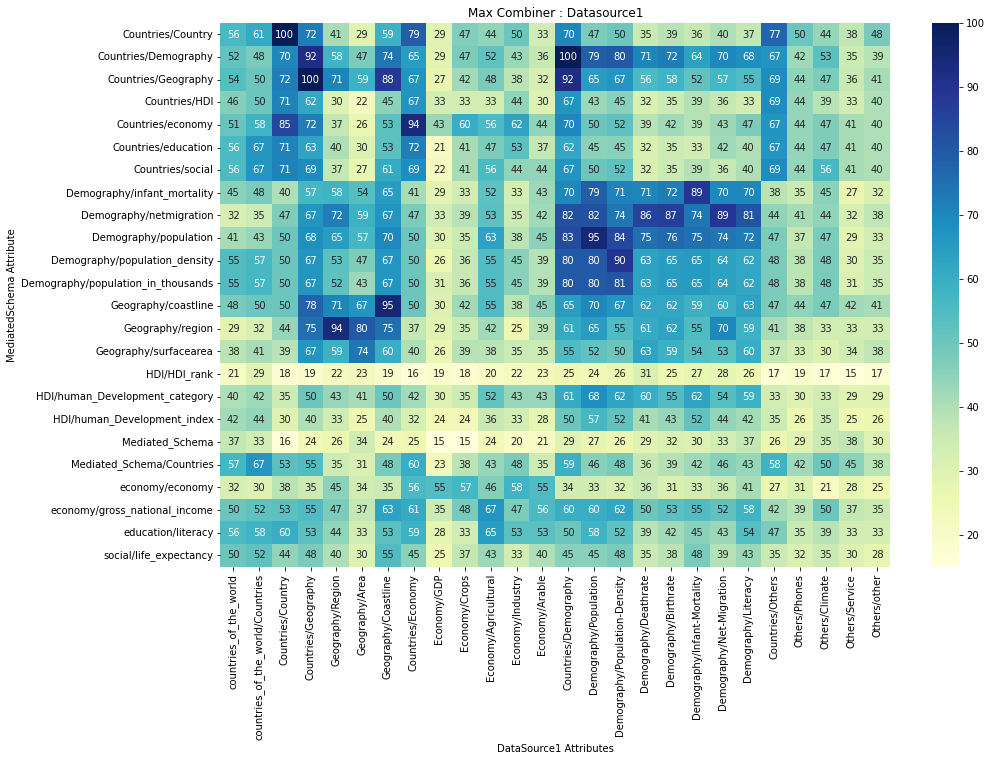

In [48]:
showData(dataSource1_combine_parent_child,15,10, str(ds1_combiner_name_parent_child) + ' Combiner : Datasource1', 'DataSource1 Attributes', 'MediatedSchema Attribute')

## Datasource 2

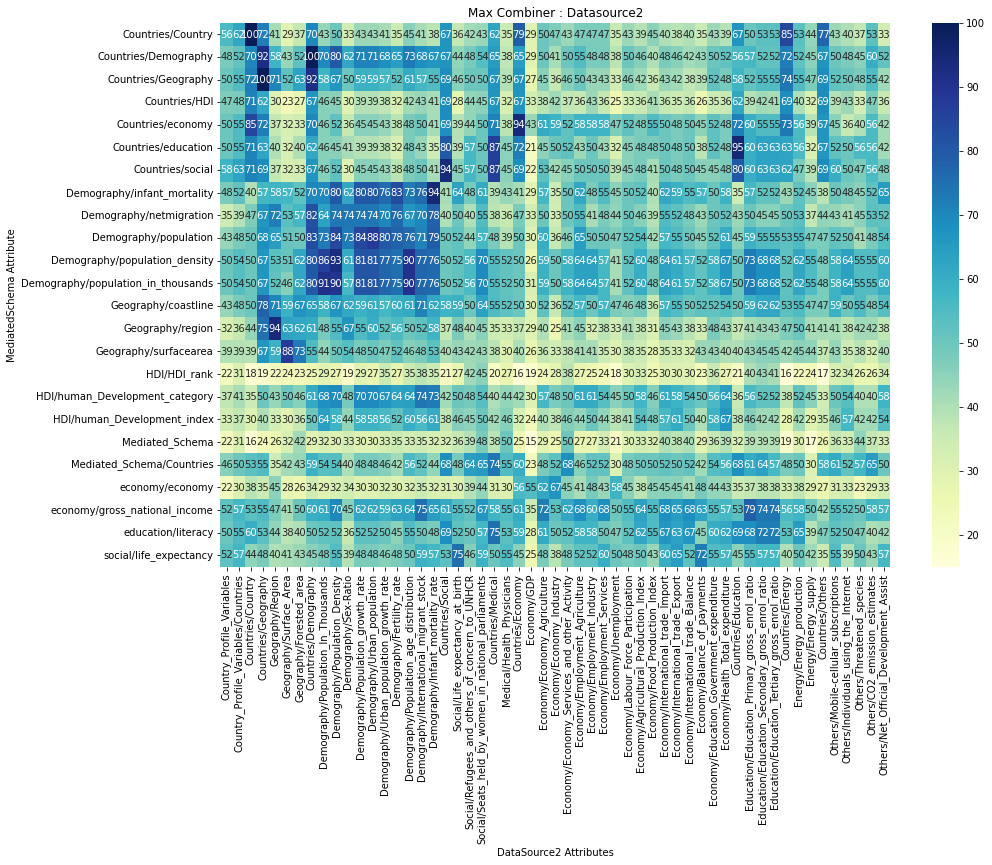

In [49]:
showData(dataSource2_combine_parent_child,15,10, str(ds1_combiner_name_parent_child) + ' Combiner : Datasource2', 'DataSource2 Attributes', 'MediatedSchema Attribute')

## Datasource 3

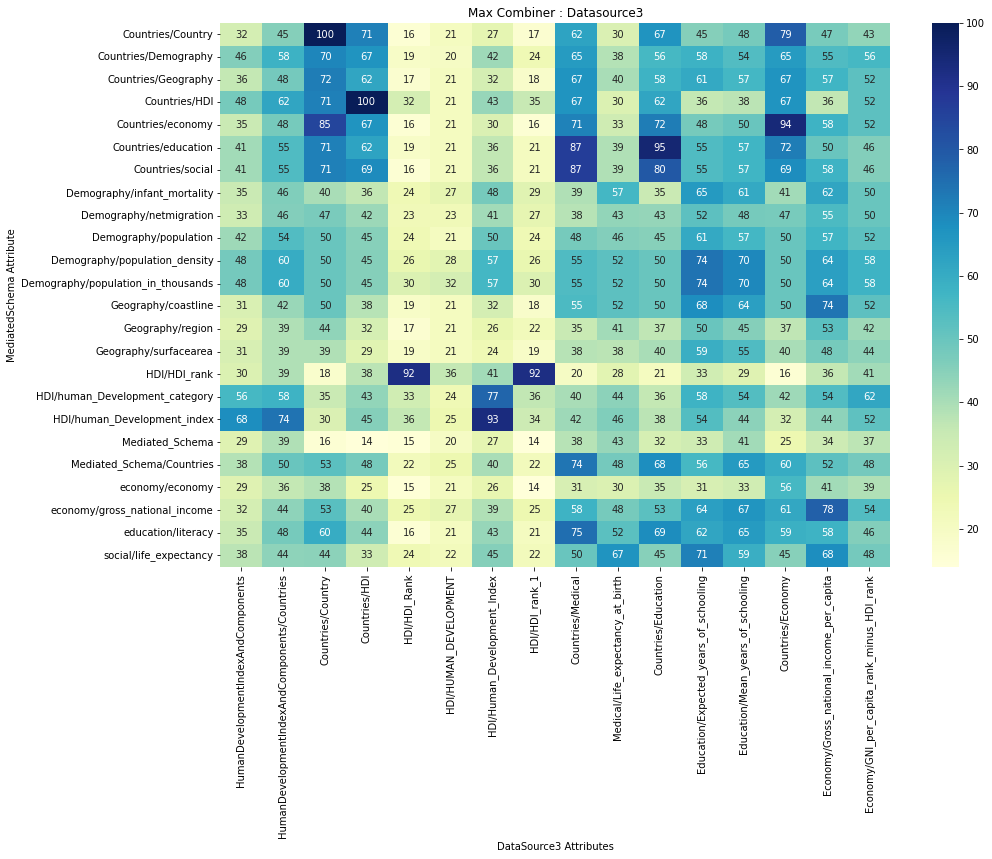

In [50]:
showData(dataSource3_combine_parent_child,15,10, str(ds1_combiner_name_parent_child) + ' Combiner : Datasource3', 'DataSource3 Attributes', 'MediatedSchema Attribute')

## Thresholding stage

In [51]:
dS1_threshold = 50
dS2_threshold = 50
dS3_threshold = 50

dataSource1_thresholded_parent_child = apply_threshold(dataSource1_combine_parent_child, dS1_threshold)
dataSource2_thresholded_parent_child = apply_threshold(dataSource2_combine_parent_child, dS2_threshold)
dataSource3_thresholded_parent_child = apply_threshold(dataSource3_combine_parent_child, dS3_threshold)

## Selection Stage

In [52]:
dataSource1_cardinality_parent_child, dataSource1_selected_parent_child = apply_cardinality_one_to_one(dataSource1_thresholded_parent_child)
dataSource2_cardinality_parent_child, dataSource2_selected_parent_child = apply_cardinality_one_to_one(dataSource2_thresholded_parent_child)
dataSource3_cardinality_parent_child, dataSource3_selected_parent_child = apply_cardinality_one_to_one(dataSource3_thresholded_parent_child)

### Convert selected cells to binary (0,1)

In [53]:
dataSource1_selected_parent_child = convert_to_ones(dataSource1_selected_parent_child)
dataSource2_selected_parent_child = convert_to_ones(dataSource2_selected_parent_child)
dataSource3_selected_parent_child = convert_to_ones(dataSource3_selected_parent_child)

## Datasource 1

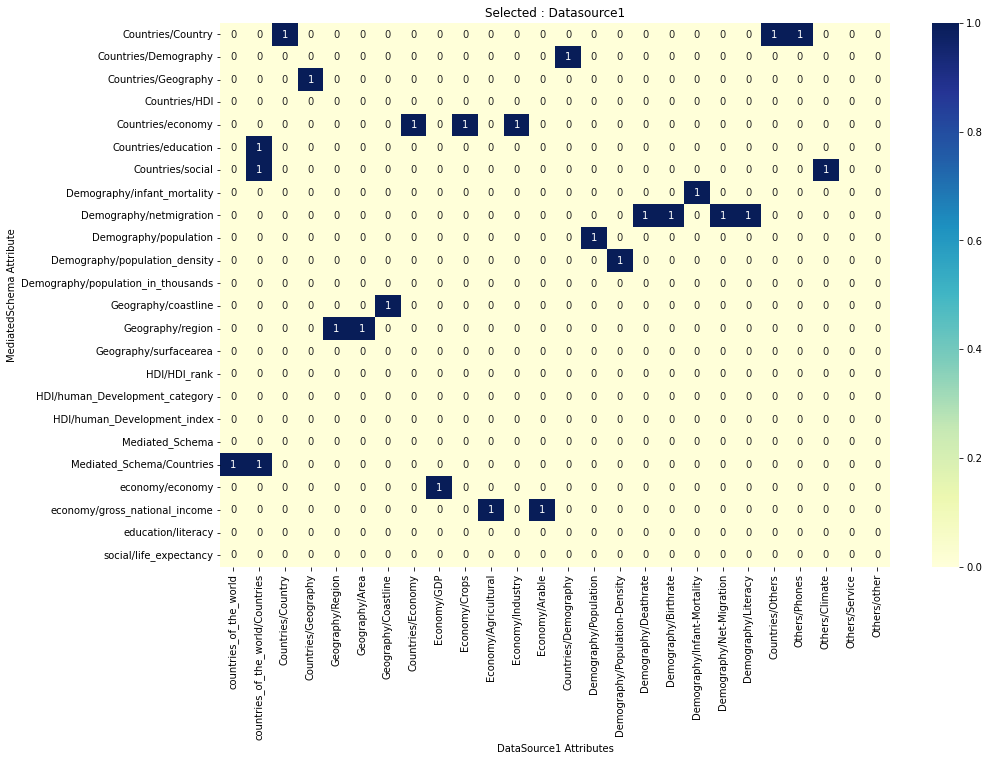

In [54]:
showData(dataSource1_selected_parent_child,15,10, 'Selected : Datasource1', 'DataSource1 Attributes', 'MediatedSchema Attribute')

## Datasource 2

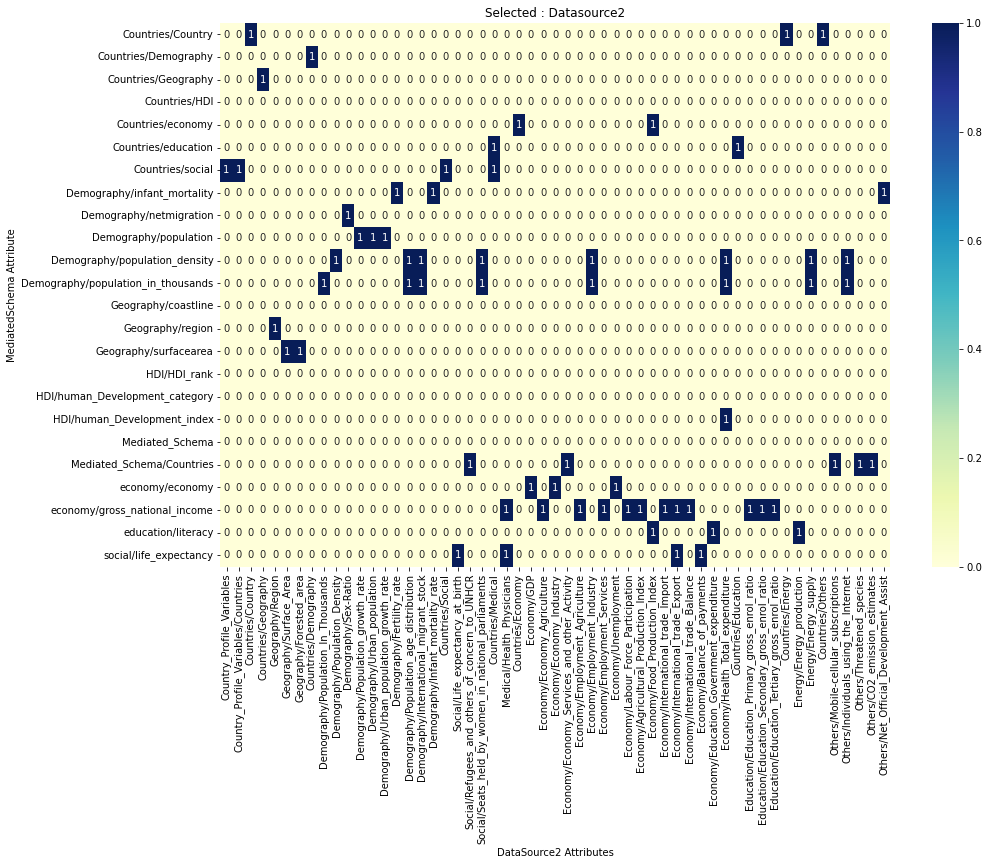

In [55]:
showData(dataSource2_selected_parent_child,15,10, 'Selected : Datasource2', 'DataSource2 Attributes', 'MediatedSchema Attribute')

## Datasource 3

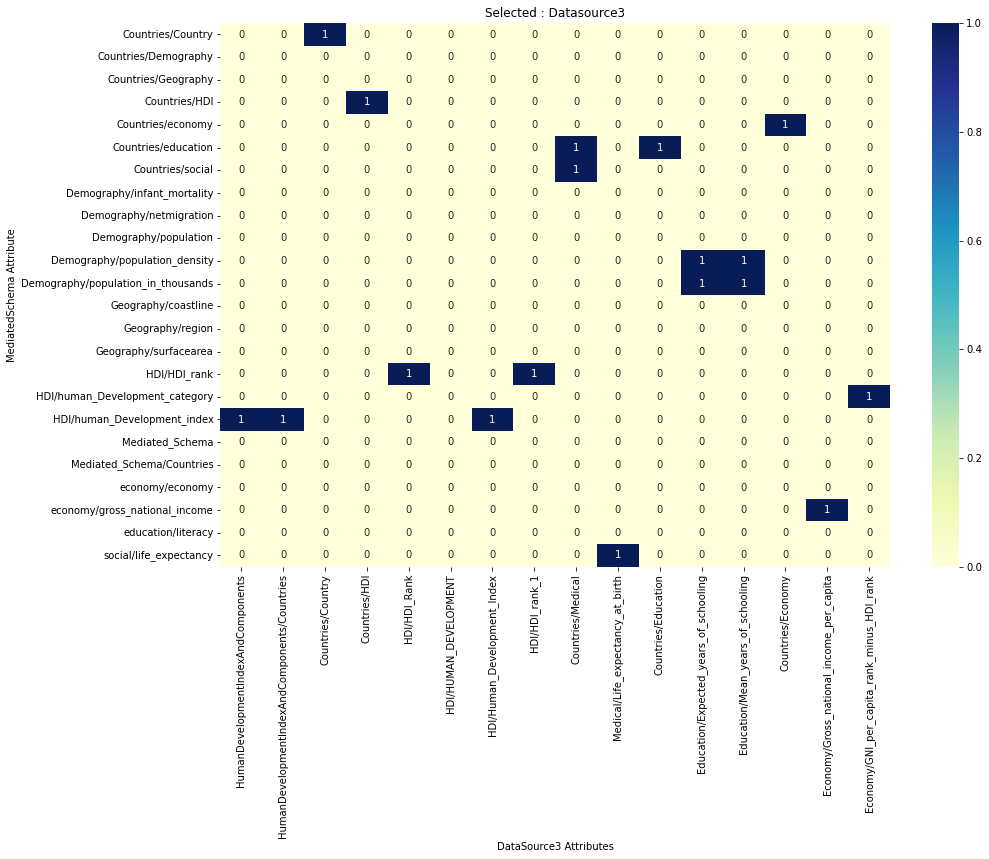

In [56]:
showData(dataSource3_selected_parent_child,15,10, 'Selected : Datasource3', 'DataSource3 Attributes', 'MediatedSchema Attribute')

## Performance metrics calculation

In [57]:
file11 = 'C:/Users/miste/CountriesOfTheWorldTask3ParentChild_1_.csv'
file12 = 'C:/Users/miste/groundTruthCountryProfVarsTask3ParentChild_2_.csv'
file13 = 'C:/Users/miste/groundTruthHDIParentChild_3_.csv'

In [58]:
ground_truth1_parent_child = pd.read_csv(file11,index_col=0)
ground_truth2_parent_child = pd.read_csv(file12,index_col=0)
ground_truth3_parent_child = pd.read_csv(file13,index_col=0)

In [59]:
ground_truth1_parent_child_sorted = ground_truth1_parent_child.sort_index()
ground_truth2_parent_child_sorted = ground_truth2_parent_child.sort_index()
ground_truth3_parent_child_sorted = ground_truth3_parent_child.sort_index()

## Datasource 1

In [60]:
showMetrics(ground_truth1_parent_child_sorted, dataSource1_selected_parent_child)

Presicion: 0.46153846153846156
Recall: 0.9230769230769231
F1 score: 0.6153846153846155


## Datasource 2

In [61]:
showMetrics(ground_truth2_parent_child_sorted, dataSource2_selected_parent_child)

Presicion: 0.1791044776119403
Recall: 0.8
F1 score: 0.29268292682926833


## Datasource 3

In [62]:
showMetrics(ground_truth3_parent_child_sorted, dataSource3_selected_parent_child)

Presicion: 0.4444444444444444
Recall: 0.8
F1 score: 0.5714285714285714
